In [149]:
library('ggplot2')
library('reshape2')
library('ggpubr')
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
library(Hmisc)
library(gridExtra)
library("survminer")
library(dplyr)
library(stringr)
library(survminer)
library(tidyr)
source("../../src/tools.R")
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 250, # set the maximum number of rows displayed
        repr.matrix.max.cols = 250) # set the maximum number of columns displayed

In [150]:

tmp <-read.table('../prognosis/Prognosis_locked/handovercompiled.Yanis.080919.csv',sep=",",header=T)
rownames(tmp) <- tmp$data_pd
cols_to_keep <- colnames(tmp)
master <- read.table('../../data/initial_dataset/Master_04_10_2019.csv',sep=",",header=T)
rownames(master) <- master$data_pd
df <- read.table('../clustering/clustering_Final_1/df_final_full_component.tsv')
df_merge <- merge(df,master[,cols_to_keep],by=0)
rownames(df_merge) <- df_merge$Row.names
df_merge <- df_merge[-1]

# keep only patients with AML 17
df_merge$AMLID <- as.character(df_merge$AMLID)
df_merge$MRD1 <- as.character(df_merge$MRD1)
df_merge <- df_merge[grep("17-", df_merge$AMLID),]
df_merge$MRD_status <- ifelse(df_merge$MRD1=="CR,MRD-" ,"CR,MRD-",
                         ifelse(df_merge$MRD1=="CR,MRD+" ,"CR,MRD+","_others"))   ## _others instead of others for color purposes
df_merge[is.na(df_merge$MRD_status),"MRD_status"] <- "_others"
df_merge <- df_merge[!is.na(df_merge$OS_CR),]


genes <- colnames(df_merge[,c(5:88)])

cytos <- colnames(df_merge[,c(89:158)])

eln <- colnames(df_merge[,c(2,3,4)])
comp <- colnames(df_merge[,c(170:186)])

all_gen <- c(5:88)
vect <- apply(X=df_merge[,all_gen],2,FUN=function(x) 100*length(which(x==1))/dim(df_merge)[1])
gen <- colnames(df_merge[,match(names(vect[vect>=2]),names(df_merge))])

all_cyto <- c(89:158)
vect <- apply(X=df_merge[,all_cyto],2,FUN=function(x) 100*length(which(x==1))/dim(df_merge)[1])
cyto <- colnames(df_merge[,match(names(vect[vect>=2]),names(df_merge))])

clin <- colnames(df_merge[,c(159:165)])
demo <- colnames(df_merge[,c(166:167)])

In [151]:
val <- c("#59A08B","#EE9937","#5C5C5C","#0072B2")

In [152]:
plot_surv <-function(fit,tmp,submain="",vals=val,legend="top",risk.tab=T, leg.labs = "",remove=F,y=""){
    p <-ggsurvplot(fit,  main = "Survival curve",risk.table=risk.tab,submain = submain,palette=vals,legend=legend,risk.table.col = "strata",pval.size=8,pval.coord=c(0,0.05),risk.table.fontsize=10,xlab="Time (years)",ylab=y,
legend.labs=leg.labs,pval=0.01,size=4,
               linetype=1,
                  ggtheme = theme_survminer(
                 font.main = c(60, "bold", "black"),
                 font.submain = c(30, "bold.italic", "black"),
                 font.legend=35,
                 font.caption = c(30, "plain", "black"),
                 font.x = c(30, "bold.italic", "black"),
                 font.y = c(30, "bold.italic", "black"),
                 font.tickslab = c(30, "plain", "black")))
    if(remove==T) {
        p <-ggsurvplot(fit,  pval = TRUE,main = "Survival curve",risk.table=risk.tab,submain = submain,palette=vals,legend=legend,risk.table.col = "strata",pval.size=8,pval.coord=c(0,0.05),risk.table.fontsize=10,xlab="Time (years)",ylab=y,
legend.labs=leg.labs,
               linetype=1,size=4,
                  ggtheme = theme_survminer(
                 font.main = c(60, "bold", "black"),
                 font.submain = c(30, "bold.italic", "black"),
                 font.legend=25,
                 font.caption = c(30, "plain", "black"),
                 font.x = c(30, "bold.italic", "black"),
                 font.y = c(30, "bold.italic", "black"),
                 font.tickslab = c(30, "plain", "black")))
                      
                      
    }
    p$plot

}

In [153]:
# set_notebook_plot_size(20,10)
plots_KM_MRD <- function(tmp=df_merge,fit,strat="all",leg.labs=""){

    if (nrow(tmp)>20){
        
        ## specific p value
        m <- "no pvalue"
        try(res <- pairwise_survdiff(Surv(RFSyears, RFSStatus)~MRD_status,data = tmp))
        try(if(res$p.value["CR,MRD+","CR,MRD-"] <0.0001){
            m <- paste("pMRD <0.0001")
        }else if(res$p.value["CR,MRD+","CR,MRD-"] >0.0001){
            m <- paste("pMRD = ",round(res$p.value["CR,MRD+","CR,MRD-"],4),sep="")
        }else {m <- "no pvalue"})
        ##
   
        p <- ggsurvplot(fit,  pval=m,pval.coord=c(0,0.05),pval.size=8,
                            submain = paste("RFS for ",strat,sep=""),risk.table=F,palette=c("#5C5C5C","#59A08B","#EE9937","#0072B2"),legend.labs=leg.labs,risk.table.col = "strata",legend="top",legend.title="",
                        ,risk.table.fontsize=10,xlab="Time (years)",ylab="",
               linetype=1,size=4,
                  ggtheme = theme_survminer(
                 font.main = c(60, "bold", "black"),
                 font.submain = c(30, "bold.italic", "black"),
                 font.legend=25,
                 font.caption = c(30, "plain", "black"),
                 font.x = c(30, "bold.italic", "black"),
                 font.y = c(30, "bold.italic", "black"),
                 font.tickslab = c(30, "plain", "black")))
            
            
        surv_object <- Surv(time = tmp$OS_CR, event = tmp$DEADStatus)
        fit <- survfit(surv_object ~ MRD_status, data = tmp)
            
        ## specific p value
        m <- "no pvalue"
        try(res <- pairwise_survdiff(Surv(OS_CR, DEADStatus)~MRD_status,data = tmp))
        try(if(res$p.value["CR,MRD+","CR,MRD-"] <0.0001){
            m <- paste("pMRD <0.0001")
        }else if(res$p.value["CR,MRD+","CR,MRD-"] >0.0001){
            m <- paste("pMRD = ",round(res$p.value["CR,MRD+","CR,MRD-"],4),sep="")
        }else {m <- "no pvalue"}
            )
        ## 

        q <- ggsurvplot(fit, pval=m, pval.coord=c(0,0.05),pval.size=8,
                          main = "Survival curve",risk.table=F,submain = paste("OS CR for ",strat,sep=""),palette=c("#5C5C5C","#59A08B","#EE9937","#0072B2"),legend.labs=leg.labs,risk.table.col = "strata",legend="top",legend.title="",
                       risk.table.fontsize=10,xlab="Time (years)",ylab="Survival Probability",
               linetype=1,size=4,
                  ggtheme = theme_survminer(
                 font.main = c(60, "bold", "black"),
                 font.submain = c(30, "bold.italic", "black"),
                 font.legend=25,
                 font.caption = c(30, "plain", "black"),
                 font.x = c(30, "bold.italic", "black"),
                 font.y = c(30, "bold.italic", "black"),
                 font.tickslab = c(30, "plain", "black")))
        grid.arrange(q$plot,p$plot,ncol=2)
        }else{
            p <- ggsurvplot(fit,  pval=T,pval.coord=c(0,0.05),pval.size=8,
                            submain = paste("RFS for ",strat,sep=""),risk.table=F,palette=c("#5C5C5C","#59A08B","#EE9937","#0072B2"),legend.labs=leg.labs,risk.table.col = "strata",legend="top",legend.title="",
                        ,risk.table.fontsize=10,xlab="Time (years)",ylab="",
               linetype=1,size=4,
                  ggtheme = theme_survminer(
                 font.main = c(60, "bold", "black"),
                 font.submain = c(30, "bold.italic", "black"),
                 font.legend=25,
                 font.caption = c(30, "plain", "black"),
                 font.x = c(30, "bold.italic", "black"),
                 font.y = c(30, "bold.italic", "black"),
                 font.tickslab = c(30, "plain", "black")))
            
            q <- ggsurvplot(fit, pval=T, pval.coord=c(0,0.05),pval.size=8,
                          main = "Survival curve",risk.table=F,submain = paste("OS CR for ",strat,sep=""),palette=c("#5C5C5C","#59A08B","#EE9937","#0072B2"),legend.labs=leg.labs,risk.table.col = "strata",legend="top",legend.title="",
                       risk.table.fontsize=10,xlab="Time (years)",ylab="Survival Probability",
               linetype=1,size=4,
                  ggtheme = theme_survminer(
                 font.main = c(60, "bold", "black"),
                 font.submain = c(30, "bold.italic", "black"),
                 font.legend=25,
                 font.caption = c(30, "plain", "black"),
                 font.x = c(30, "bold.italic", "black"),
                 font.y = c(30, "bold.italic", "black"),
                 font.tickslab = c(30, "plain", "black")))
        grid.arrange(q$plot,p$plot,ncol=2)
            
        }
}

In [148]:
source("tools.R")

[1] 0.0001485127

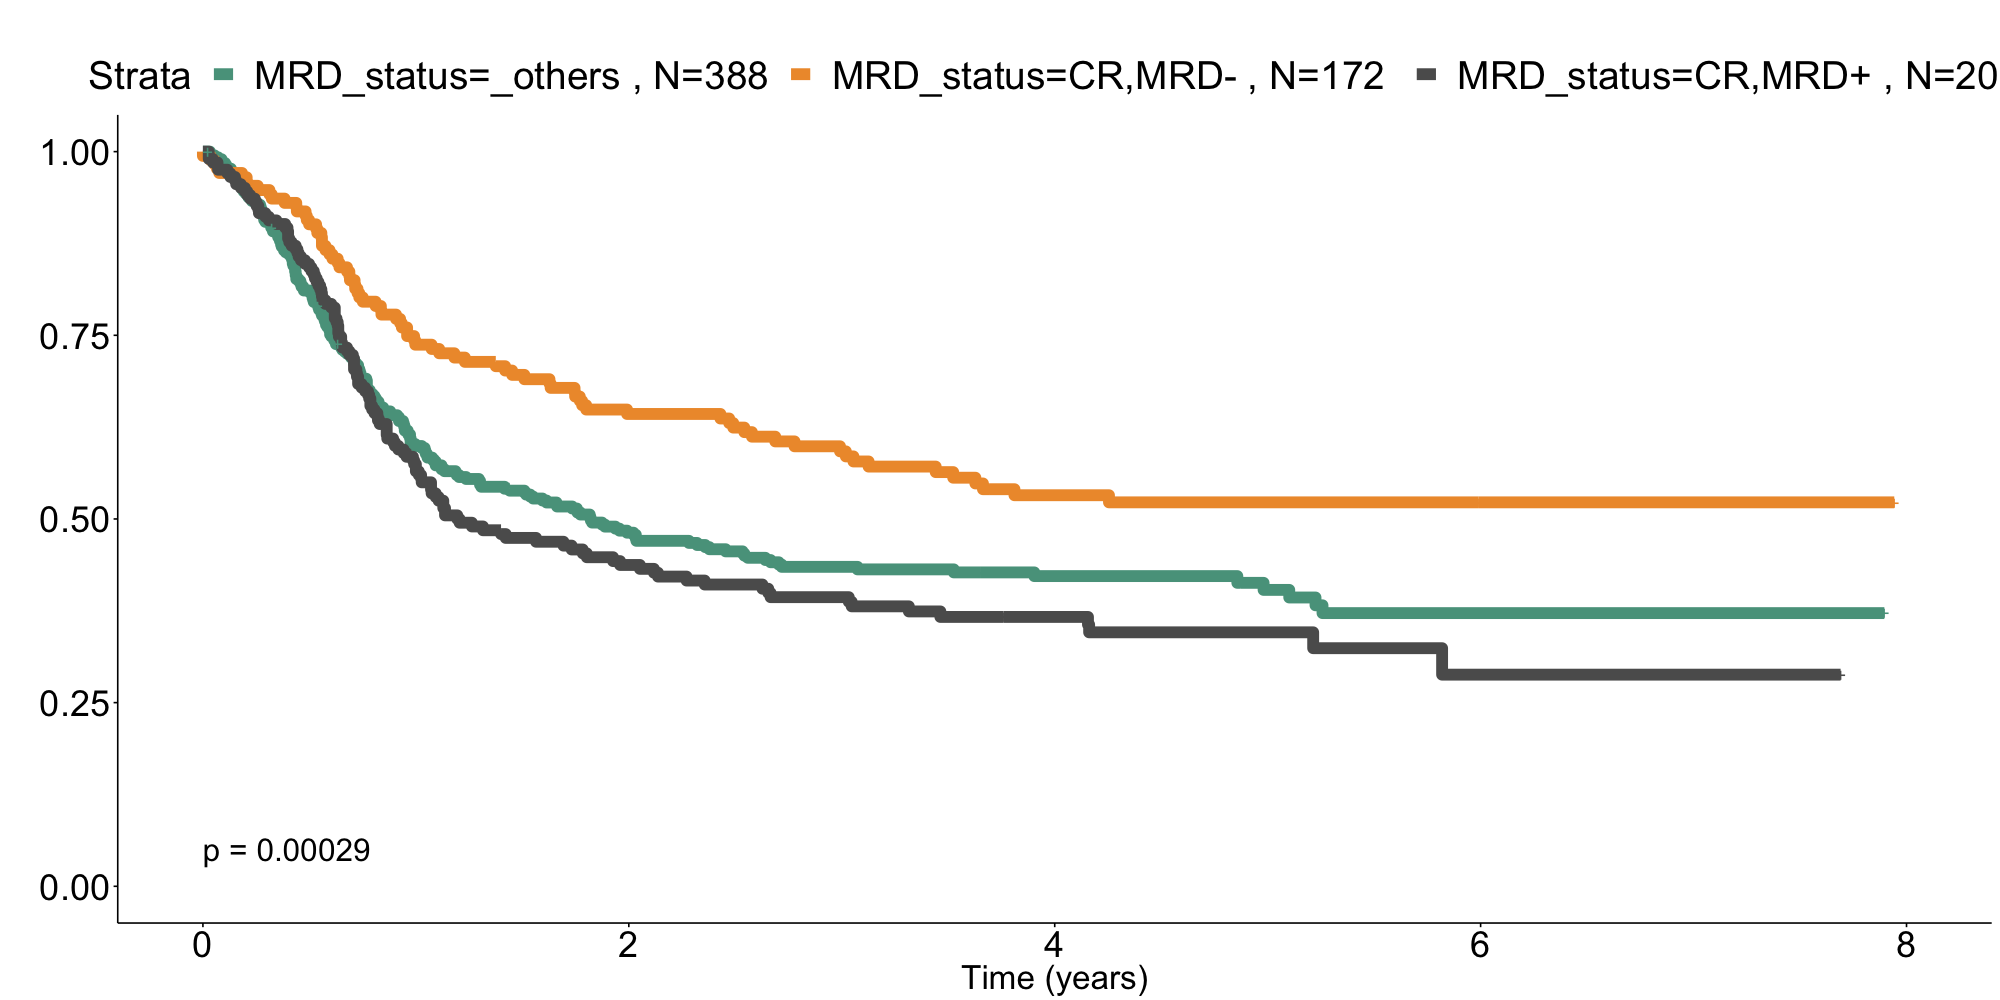

In [168]:
tmp<- df_merge[df_merge$MRD_status %in% c("CR,MRD-","CR,MRD+","_others") ,]
tmp$comparison <- tmp$MRD_status
pairwise_survdiff(Surv(RFSyears, RFSStatus)~MRD_status,data = tmp)$p.value["CR,MRD+","CR,MRD-"]
surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
fit <- survfit(surv_object ~ MRD_status, data = tmp)
plot_surv_curves(fit)

pdf 
  2

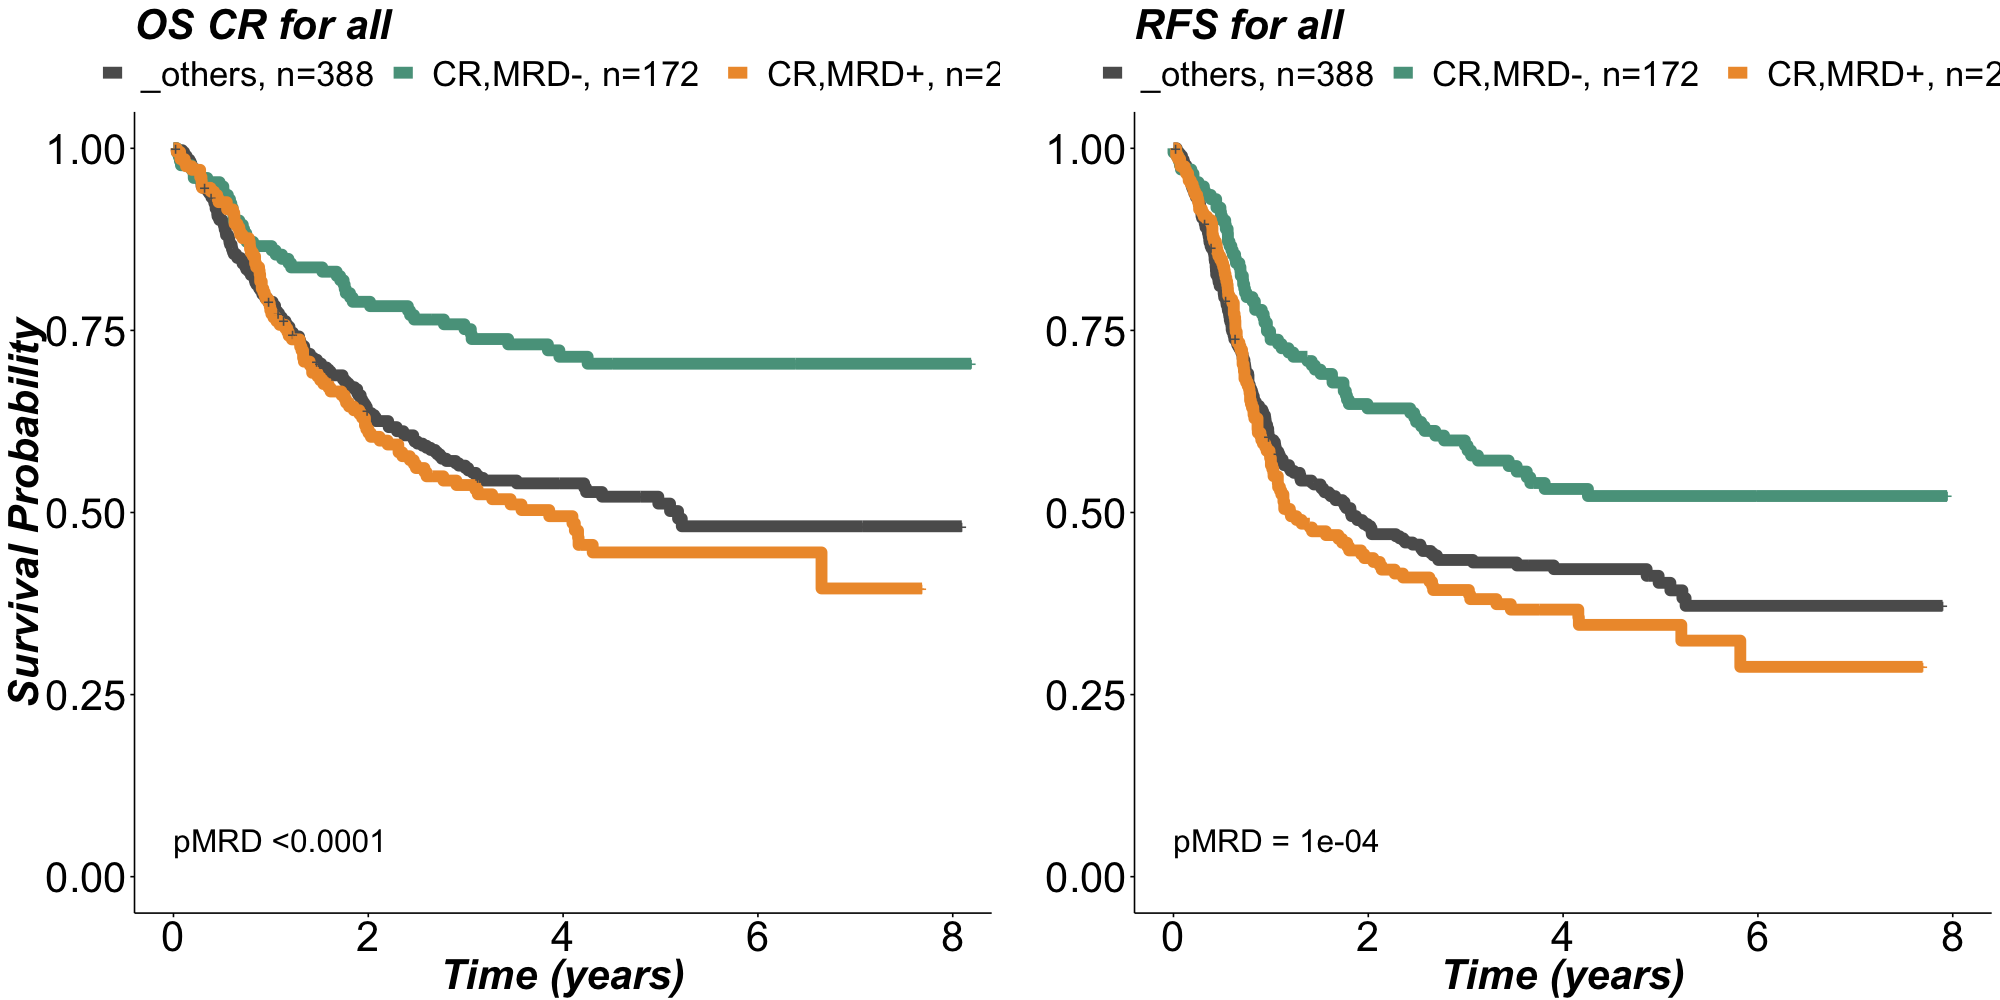

In [164]:
q <- ggplot(df_merge,aes(reorder(MRD_status,MRD_status,function(x)-length(x)),fill=MRD_status))+geom_bar()+scale_fill_manual(values=c("#5C5C5C","#59A08B","#EE9937"))+guides(fill=F)+
theme(plot.title = element_text(hjust = 0.5,size=65,face="bold"),axis.text.x = element_text(size=20,face="bold"),axis.text.y = element_text(size=20,face="bold"),axis.title.y=element_text(size=30,face="bold"))+xlab("")+ylab("Count")

set_notebook_plot_size(20,10)
tmp<- df_merge
surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
fit <- survfit(surv_object ~ MRD_status, data = tmp)
p <- plots_KM_MRD(tmp=tmp,fit=fit,leg.labs=c(paste("_others",nrow(tmp[(tmp$MRD_status=="_others") & !is.na(tmp$OS_CR),]),sep=", n="),
                                                     paste("CR,MRD-",nrow(tmp[(tmp$MRD_status=="CR,MRD-") & !is.na(tmp$OS_CR),]),sep=", n="),paste("CR,MRD+",nrow(tmp[(tmp$MRD_status=="CR,MRD+") & !is.na(tmp$OS_CR),]),sep=", n=")))
png("MRD_all.png",width=10000,height=2500,res=200)
grid.arrange(q,p,ncol=2)
dev.off()

# KM FOR ELN

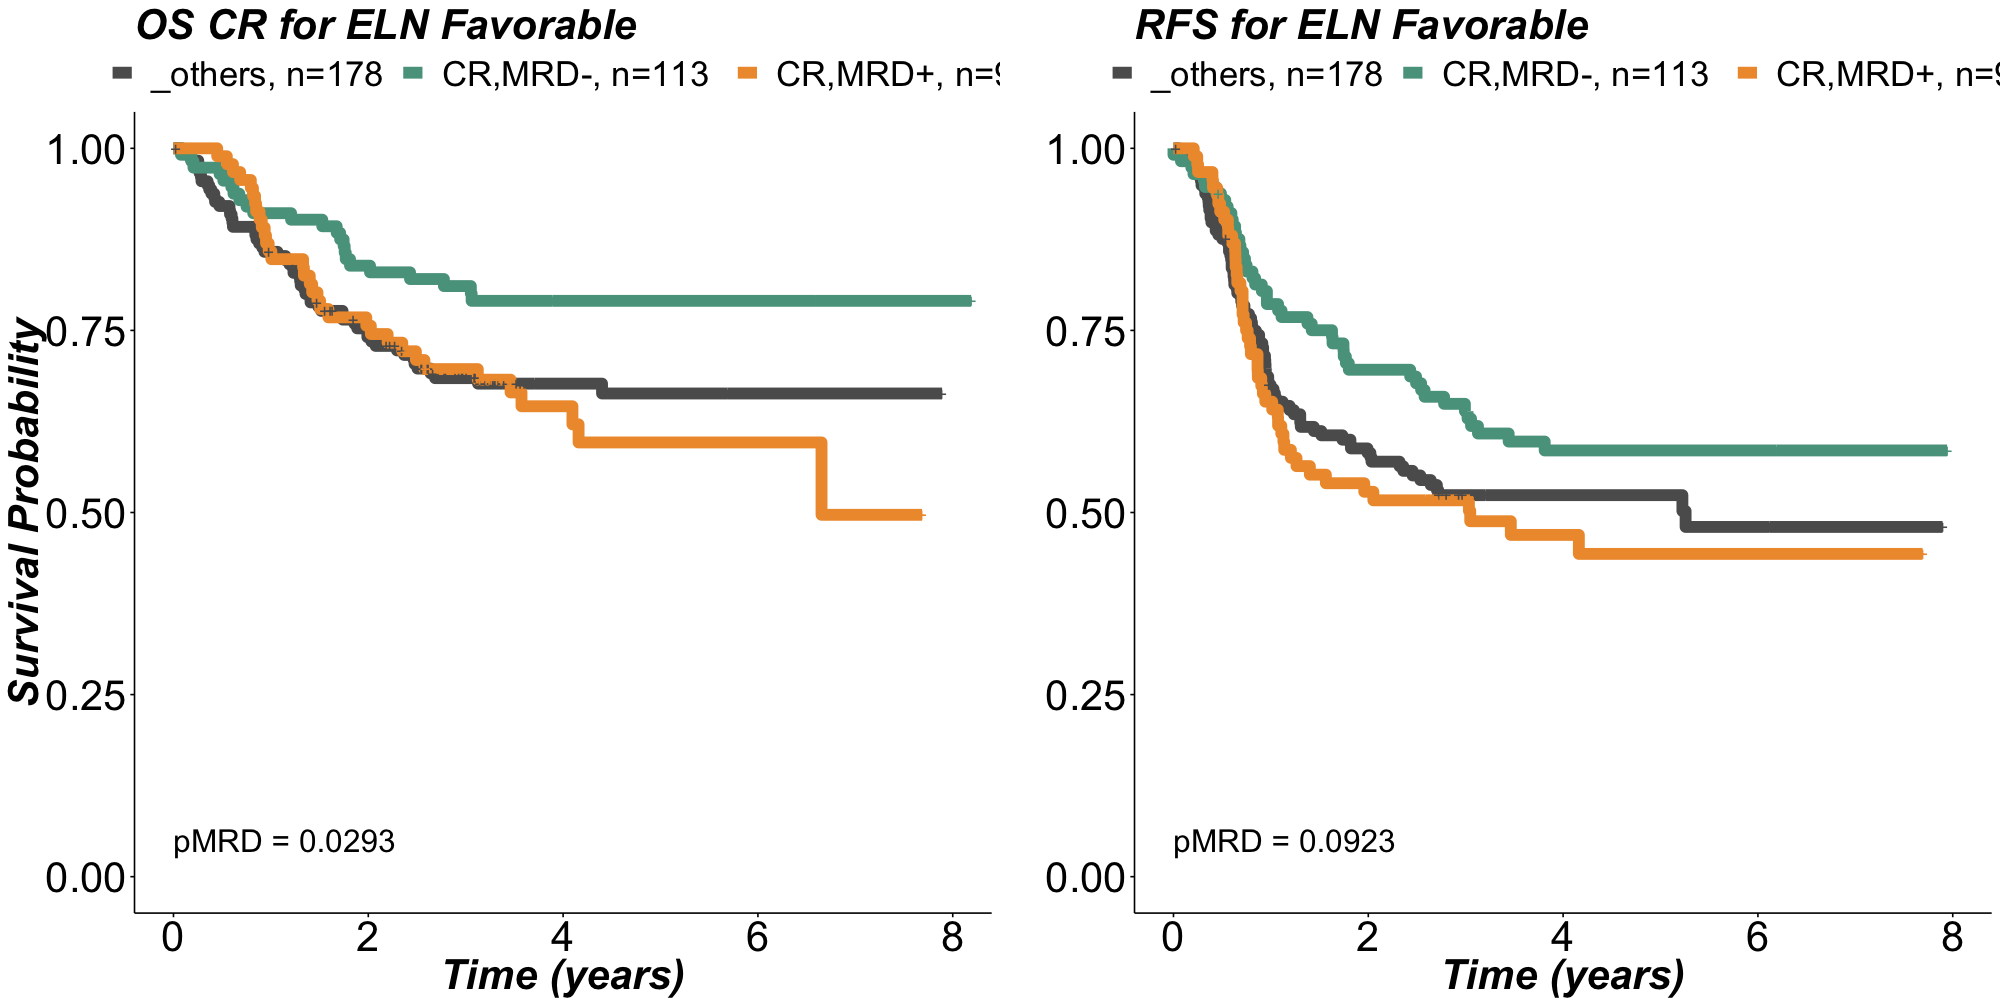

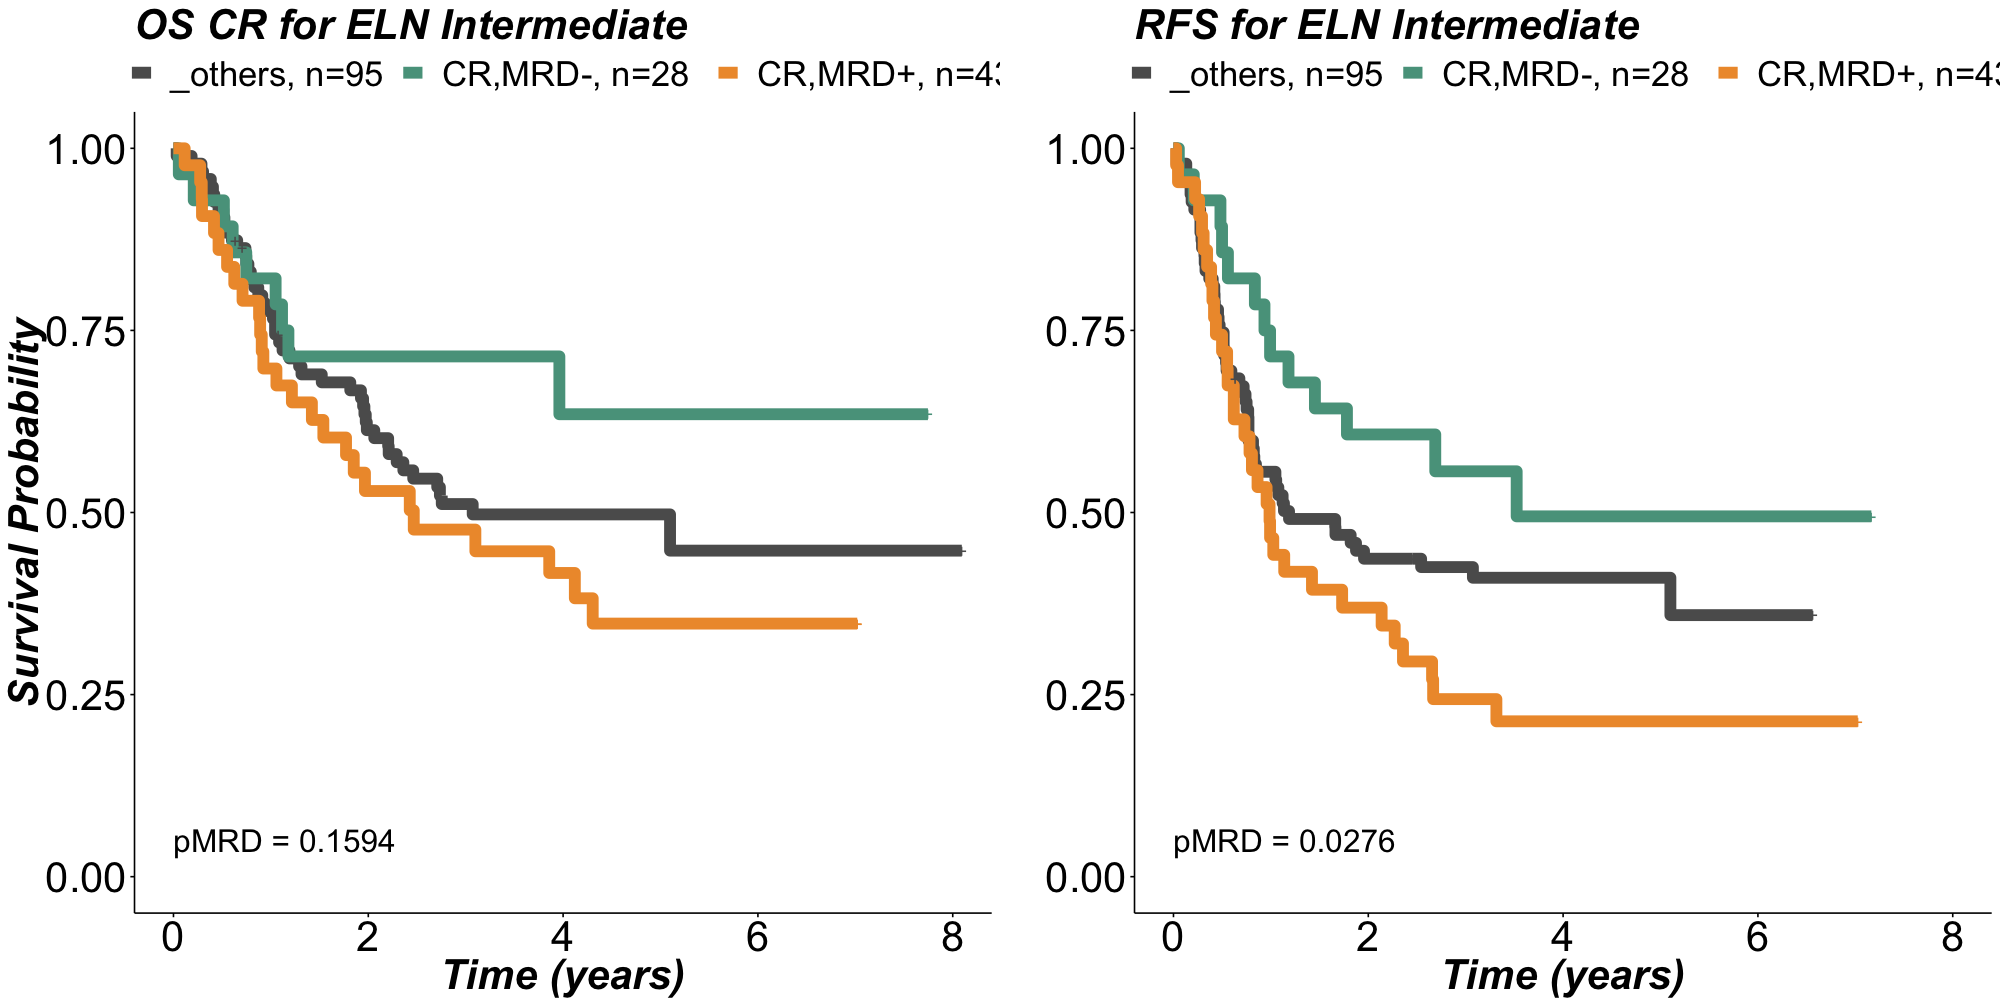

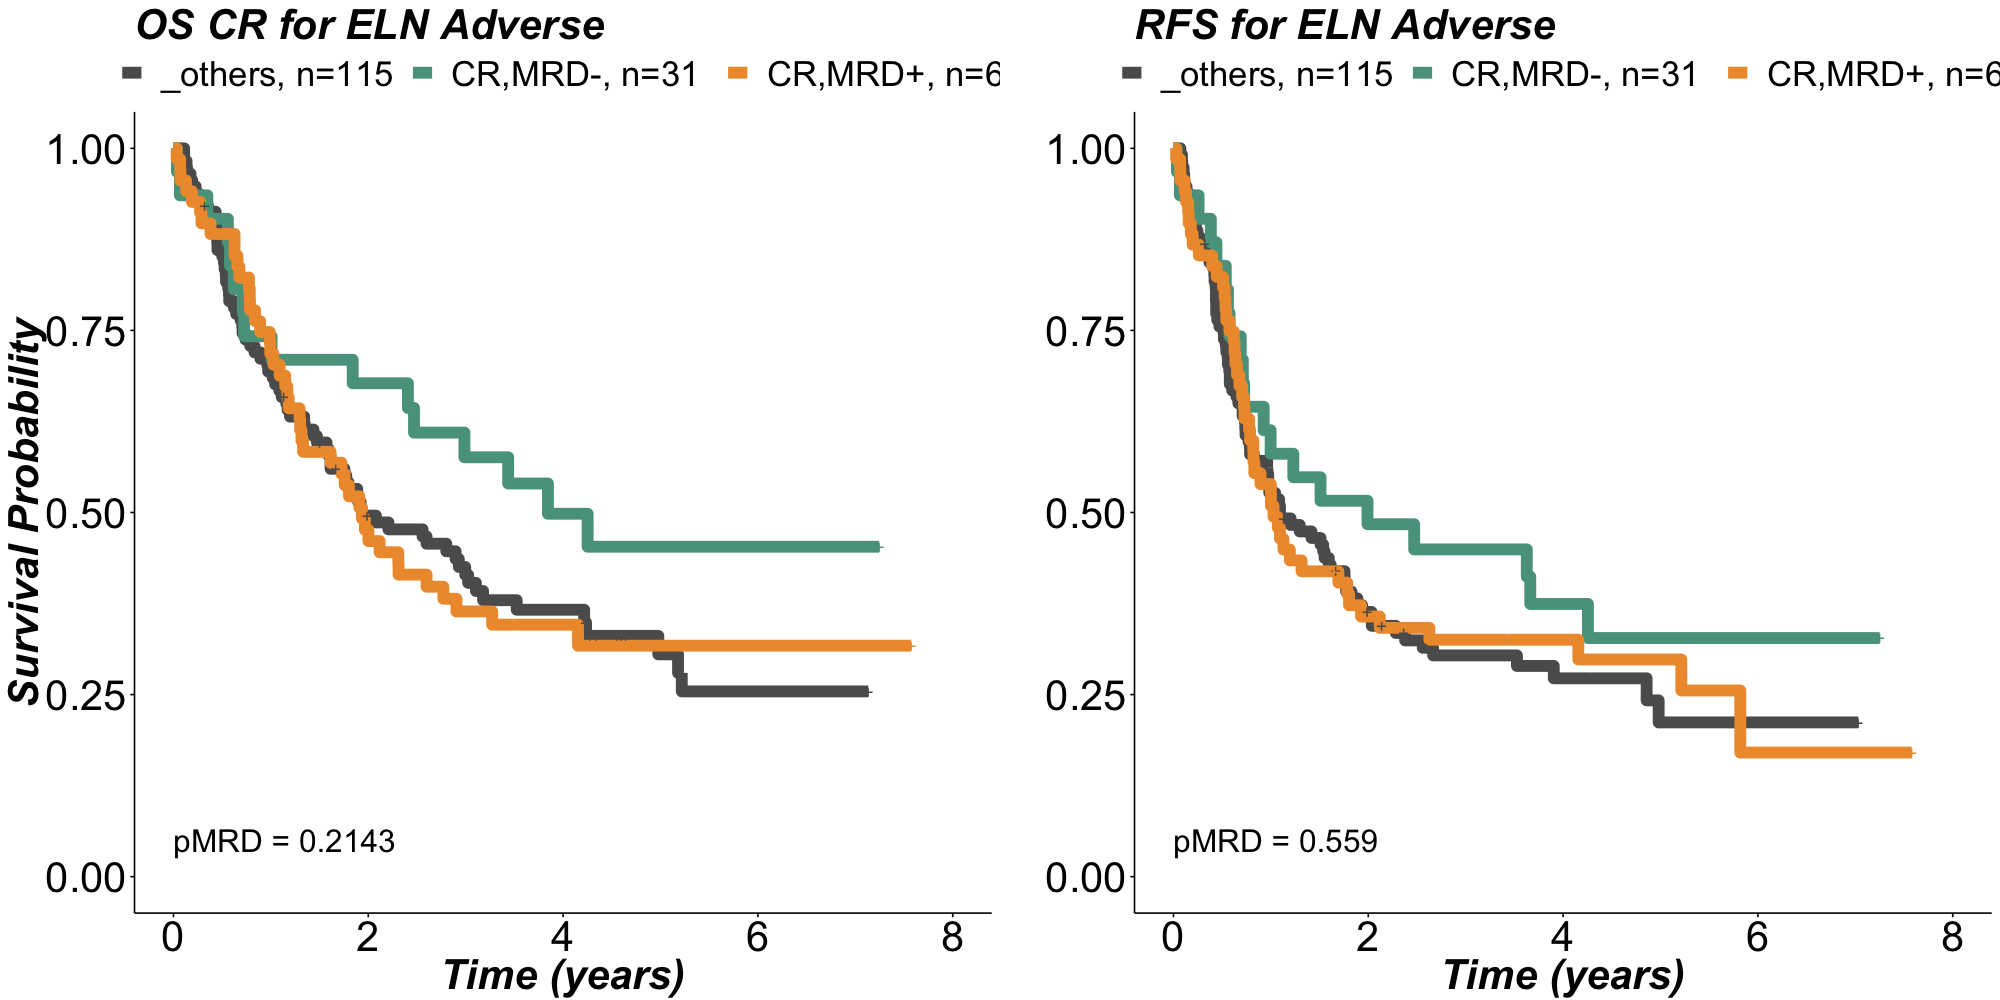

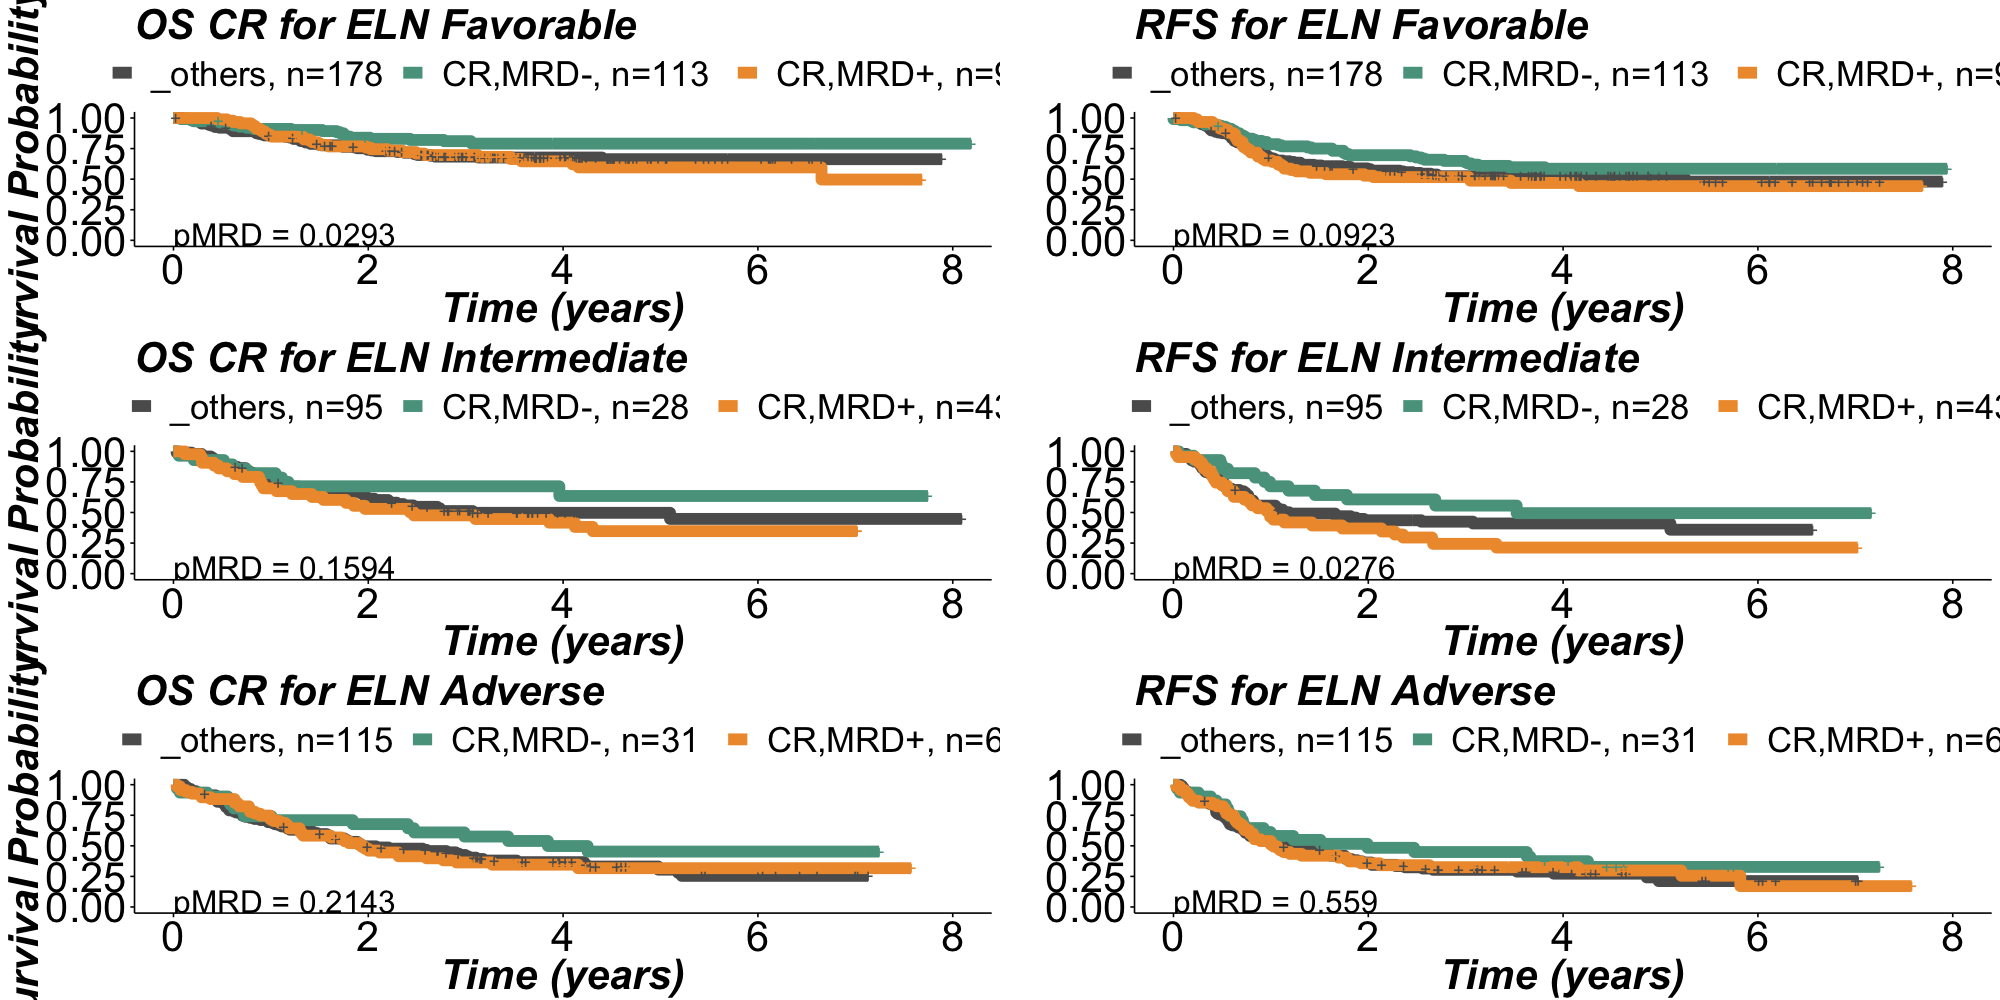

In [165]:
p <- list()
for (i in c(1:3)){
    if(i==1){
        tmp <- df_merge[df_merge$eln_2017_favorable==1,]
        strat= "ELN Favorable"
    }else if(i==2){
        tmp <- df_merge[df_merge$eln_2017_intermediate==1,]
        strat= "ELN Intermediate"
    }else{
        tmp <- df_merge[df_merge$eln_2017_adverse==1,]
        strat= "ELN Adverse"
    }
    surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
    fit <- survfit(surv_object ~ MRD_status, data = tmp)
    p[[i]] <- plots_KM_MRD(tmp=tmp,strat=strat,fit=fit,leg.labs=c(paste("_others",nrow(tmp[(tmp$MRD_status=="_others") & !is.na(tmp$OS_CR),]),sep=", n="),
                                                         paste("CR,MRD-",nrow(tmp[(tmp$MRD_status=="CR,MRD-") & !is.na(tmp$OS_CR),]),sep=", n="),
                                                 paste("CR,MRD+",nrow(tmp[(tmp$MRD_status=="CR,MRD+") & !is.na(tmp$OS_CR),]),sep=", n=")))
    }
# png("ELN_strat_MRD.png",width=5300,height=4700,res=240)
grid.arrange(p[[1]],p[[2]],p[[3]],nrow=3)
# dev.off()

# STACKED FREQUENCY PROP GENE CYTO

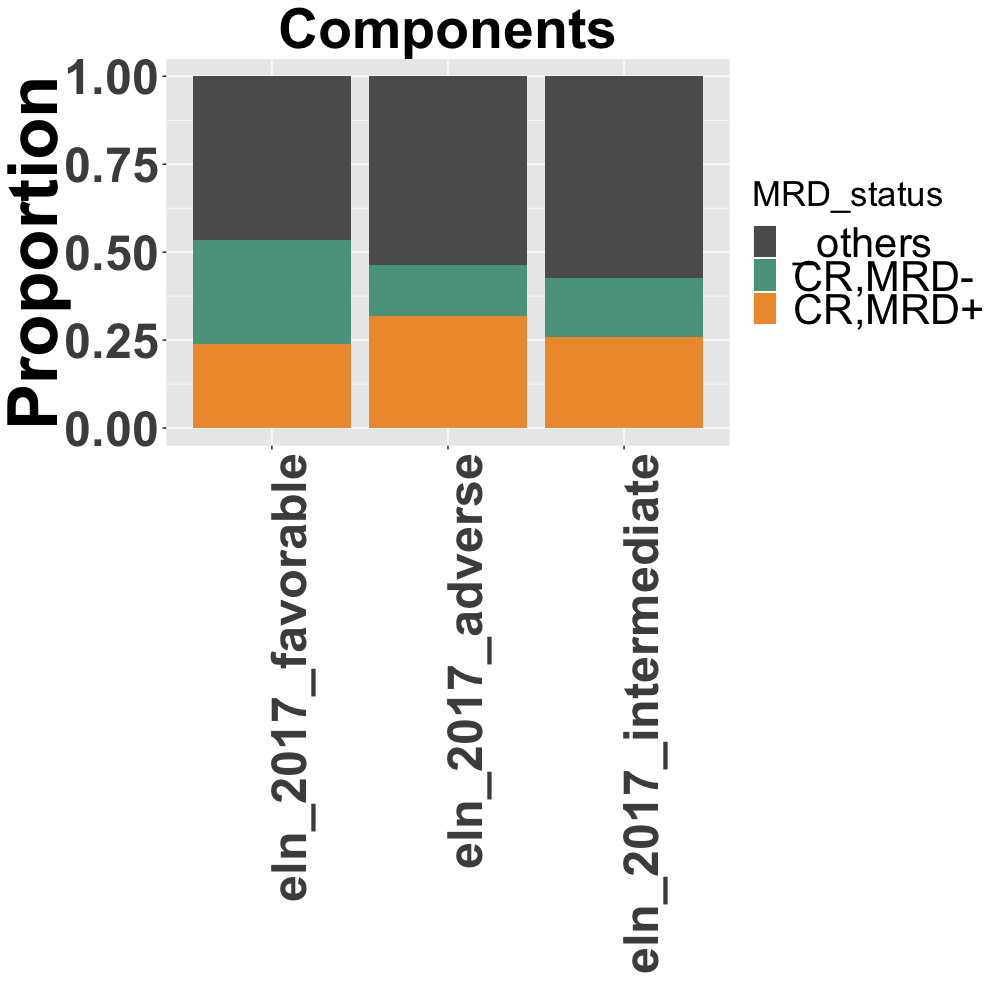

In [53]:
tmp <- NULL
for (co in c("eln_2017_adverse","eln_2017_intermediate","eln_2017_favorable")){
    if(nrow(df_merge[df_merge[,co]==1,])>0){
        tmp1 <- df_merge[df_merge[,co]==1,]
        tmp1$components <- co
        tmp <- rbind(tmp,tmp1)
    }
}
s <- ggplot(tmp,aes(x=reorder(components,components,function(x) -length(x)),fill=MRD_status))+ geom_bar(aes( y=..count../tapply(..count.., ..x.. ,sum)[..x..],fill=MRD_status)) + scale_fill_manual(values=c("#5C5C5C","#59A08B","#EE9937"))+
theme(plot.title = element_text(hjust = 0.5,size=40,face="bold"),axis.text.x = element_text(size=35,face="bold",angle=90,hjust=1),axis.text.y = element_text(size=35,face="bold"),
      axis.title.y=element_text(size=50,face="bold"),legend.text=element_text(size=30),legend.title=element_text(size=25))+xlab("")+ylab("Proportion")+ggtitle("Components")
set_notebook_plot_size(10,10)
s

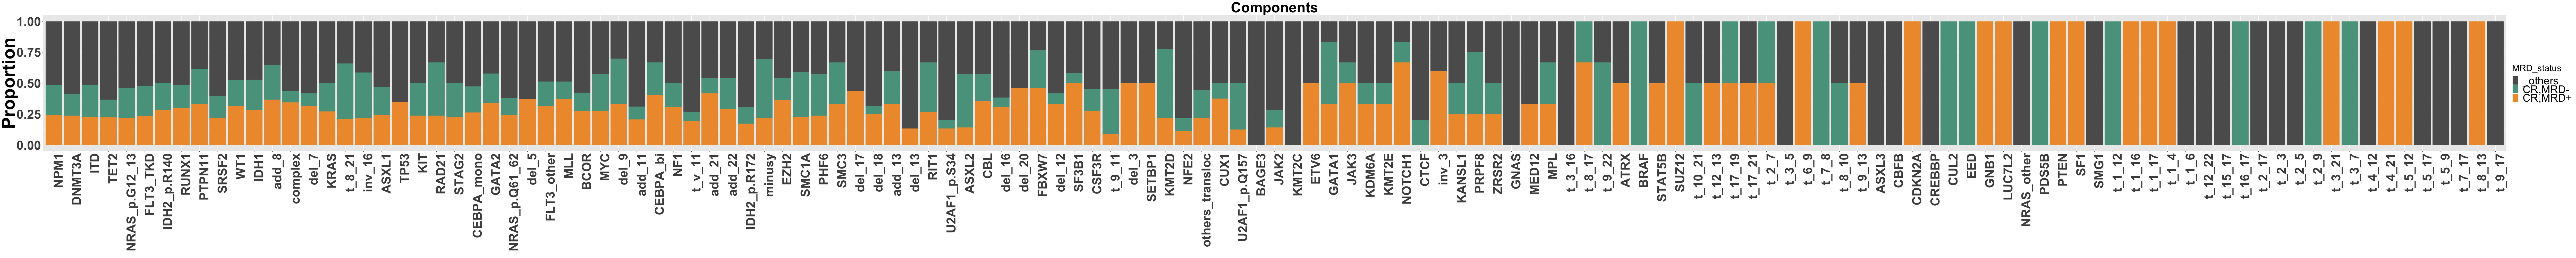

In [50]:
tmp <- NULL
for (co in c(genes,cytos)){
    if(nrow(df_merge[df_merge[,co]==1,])>0){
        tmp1 <- df_merge[df_merge[,co]==1,]
        tmp1$components <- co
        tmp <- rbind(tmp,tmp1)
    }
}
s <- ggplot(tmp,aes(x=reorder(components,components,function(x) -length(x)),fill=MRD_status))+ geom_bar(aes( y=..count../tapply(..count.., ..x.. ,sum)[..x..],fill=MRD_status)) + scale_fill_manual(values=c("#5C5C5C","#59A08B","#EE9937"))+
theme(plot.title = element_text(hjust = 0.5,size=40,face="bold"),axis.text.x = element_text(size=35,face="bold",angle=90,hjust=1),axis.text.y = element_text(size=35,face="bold"),
      axis.title.y=element_text(size=50,face="bold"),legend.text=element_text(size=30),legend.title=element_text(size=25))+xlab("")+ylab("Proportion")+ggtitle("Components")
set_notebook_plot_size(100,10)
s

# STACKED FREQUENCY PROP COMP

In [145]:
tmp <- NULL    
library(dplyr)
library(tidyr)
for (co in comp){
    tmp1 <- df_merge[df_merge[,co]==1,]
    tmp1$components <- str_replace(co,"full_component_","")
    tmp <- rbind(tmp,tmp1)
}
s <- ggplot(tmp,aes(x=reorder(components,components,function(x) -length(x)),fill=MRD_status))+ geom_bar(aes( y=..count../tapply(..count.., ..x.. ,sum)[..x..],fill=MRD_status)) + scale_fill_manual(values=c("#5C5C5C","#59A08B","#EE9937"))+
theme(plot.title = element_text(hjust = 0.5,size=40,face="bold"),axis.text.x = element_text(size=35,face="bold",angle=90,hjust=1),axis.text.y = element_text(size=35,face="bold"),
      axis.title.y=element_text(size=50,face="bold"),legend.text=element_text(size=30),legend.title=element_text(size=25))+xlab("")+ylab("Proportion")+ggtitle("Components")

png("MRD_stacked_prop.png",width=5000,height=5000,res=250) 
s
dev.off()

pdf 
  2

# CORRELATES FOR MRD

In [96]:

tmp <- df_merge
tmp$eln_2017 <- ifelse(df_merge$eln_2017==1,"adverse",
                           ifelse(df_merge$eln_2017==2,"intermediate","favorable"))
p <- ggplot(tmp,aes(x=reorder(eln_2017,eln_2017,function(x) -length(x)),fill=MRD_status))+ geom_bar(aes(fill=MRD_status)) + scale_fill_manual(values=c("#5C5C5C","#59A08B","#EE9937"))+
theme(plot.title = element_text(hjust = 0.5,size=40,face="bold"),axis.text.x = element_text(size=20,face="bold"),axis.text.y = element_text(size=20,face="bold"),
      axis.title.y=element_text(size=30,face="bold"),legend.text=element_text(size=25),legend.title=element_text(size=25),legend.position="top")+xlab("")+ylab("Count")+ggtitle("ELN")

tmp <- df_merge
tmp$perf_status <- factor(tmp$perf_status)
tmp$eln_2017 <- ifelse(df_merge$eln_2017==1,"adverse",
                           ifelse(df_merge$eln_2017==2,"intermediate","favorable"))
q <- ggplot(tmp,aes(x=reorder(perf_status,perf_status,function(x) -length(x)),fill=MRD_status))+ geom_bar(aes(fill=MRD_status)) + scale_fill_manual(values=c("#5C5C5C","#59A08B","#EE9937"))+
theme(plot.title = element_text(hjust = 0.5,size=40,face="bold"),axis.text.x = element_text(size=20,face="bold"),axis.text.y = element_text(size=20,face="bold"),
      axis.title.y=element_text(size=30,face="bold"),legend.text=element_text(size=25),legend.title=element_text(size=25),legend.position="none")+xlab("")+ylab("Count")+ggtitle("Perf status")

tmp <- df_merge
tmp$age_comparison <- ifelse(tmp$age<=50,"less than 50","more than 50")

r <- ggplot(tmp,aes(x=reorder(age_comparison,age_comparison,function(x) -length(x)),fill=MRD_status))+ geom_bar(aes(fill=MRD_status)) + scale_fill_manual(values=c("#5C5C5C","#59A08B","#EE9937"))+
theme(plot.title = element_text(hjust = 0.5,size=40,face="bold"),axis.text.x = element_text(size=20,face="bold"),axis.text.y = element_text(size=20,face="bold"),
      axis.title.y=element_text(size=30,face="bold"),legend.text=element_text(size=25),legend.title=element_text(size=25),legend.position="none")+xlab("")+ylab("Count")+ggtitle("Age stratified at 50 (median)")

tmp <- NULL                         
for (co in comp){
    tmp1 <- df_merge[df_merge[,co]==1,]
    tmp1$components <- str_replace(co,"full_component_","")
    tmp <- rbind(tmp,tmp1)
}

s <- ggplot(tmp,aes(x=reorder(components,components,function(x) -length(x)),fill=MRD_status))+ geom_bar(aes(fill=MRD_status)) + scale_fill_manual(values=c("#5C5C5C","#59A08B","#EE9937"))+
theme(plot.title = element_text(hjust = 0.5,size=40,face="bold"),axis.text.x = element_text(size=20,face="bold",angle=90,hjust=1),axis.text.y = element_text(size=20,face="bold"),
      axis.title.y=element_text(size=30,face="bold"),legend.text=element_text(size=25),legend.title=element_text(size=25),legend.position="none")+xlab("")+ylab("Count")+ggtitle("Components")
                              
png("stratification_MRD.png",width=5000,height=5000,res=250)
grid.arrange(s,nrow=1)
dev.off()

pdf 
  2

# STRAT BY COMP

In [97]:
options(warn=-1)
set_notebook_plot_size(30,10)
comp <- colnames(df_merge[,170:186])
# pdf("graphs/MRD/components_MRD.pdf",22,6)
for (ev in comp){
    png(paste(ev,"_MRD.png",sep=""),width=7000,height=2500,res=250)
    tmp<- df_merge[df_merge[,ev]==1,]
    surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
    fit <- survfit(surv_object ~ MRD_status, data = tmp)
    try(suppressWarnings(plots_KM_MRD(tmp=tmp,fit=fit,strat=str_replace(ev,"full_component_",""),leg.labs=c(paste("_others",nrow(tmp[(tmp$MRD_status=="_others") & !is.na(tmp$OS_CR),]),sep=", n="),
                                                     paste("CR,MRD-",nrow(tmp[(tmp$MRD_status=="CR,MRD-") & !is.na(tmp$OS_CR),]),sep=", n="),paste("CR,MRD+",nrow(tmp[(tmp$MRD_status=="CR,MRD+") & !is.na(tmp$OS_CR),]),sep=", n=")))))
    dev.off()
    }

Error in ggsurvplot_df(d, fun = fun, color = color, palette = palette,  : 
  The length of legend.labs should be 1
Error in ggsurvplot_df(d, fun = fun, color = color, palette = palette,  : 
  The length of legend.labs should be 1
Error in ggsurvplot_df(d, fun = fun, color = color, palette = palette,  : 
  The length of legend.labs should be 2
Error in ggsurvplot_df(d, fun = fun, color = color, palette = palette,  : 
  The length of legend.labs should be 1


# STRAT BY GENE AND CYTO

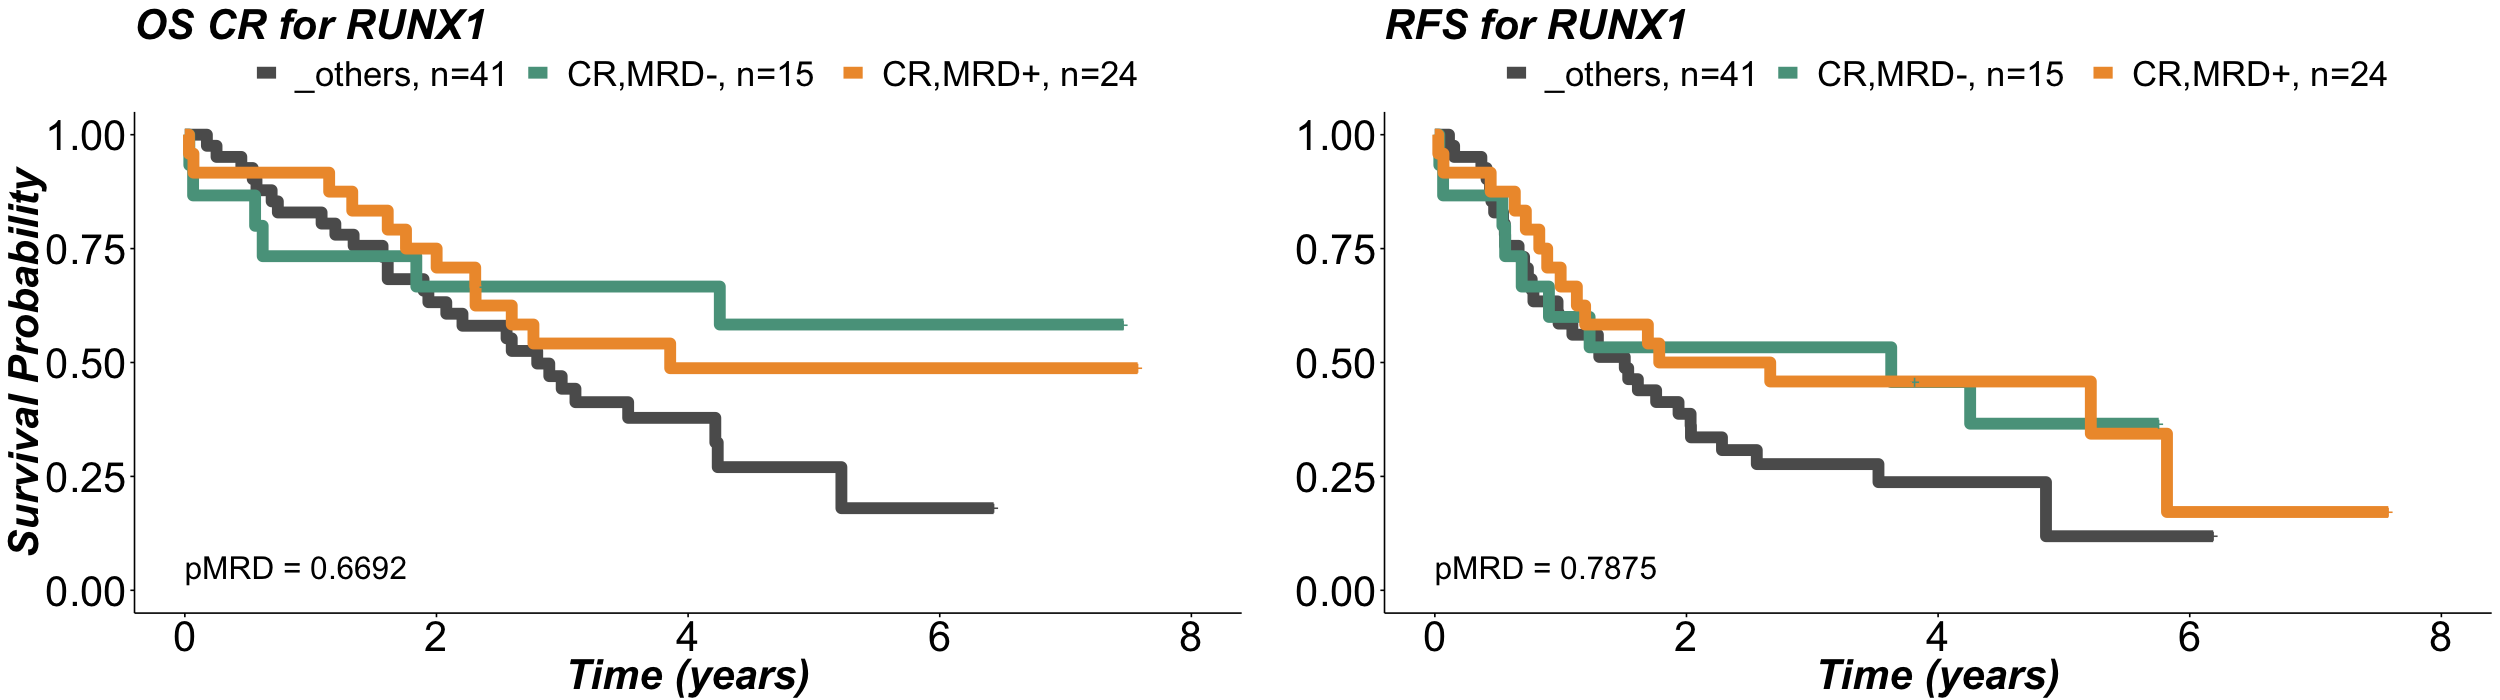

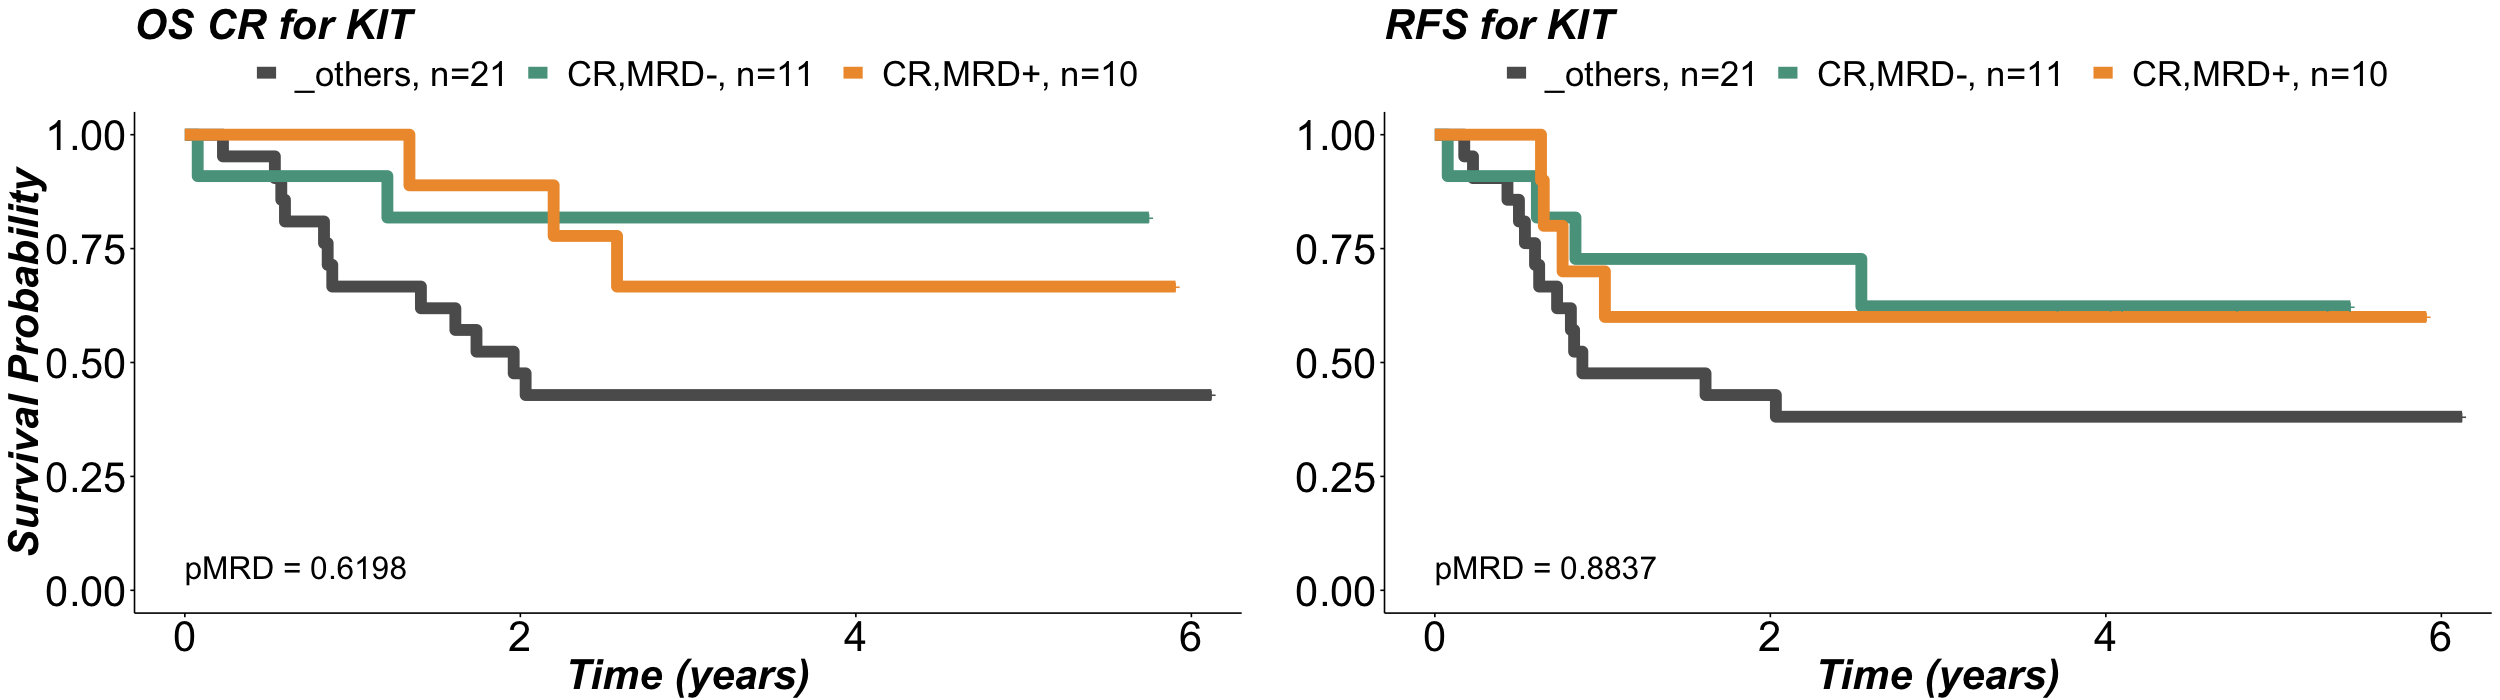

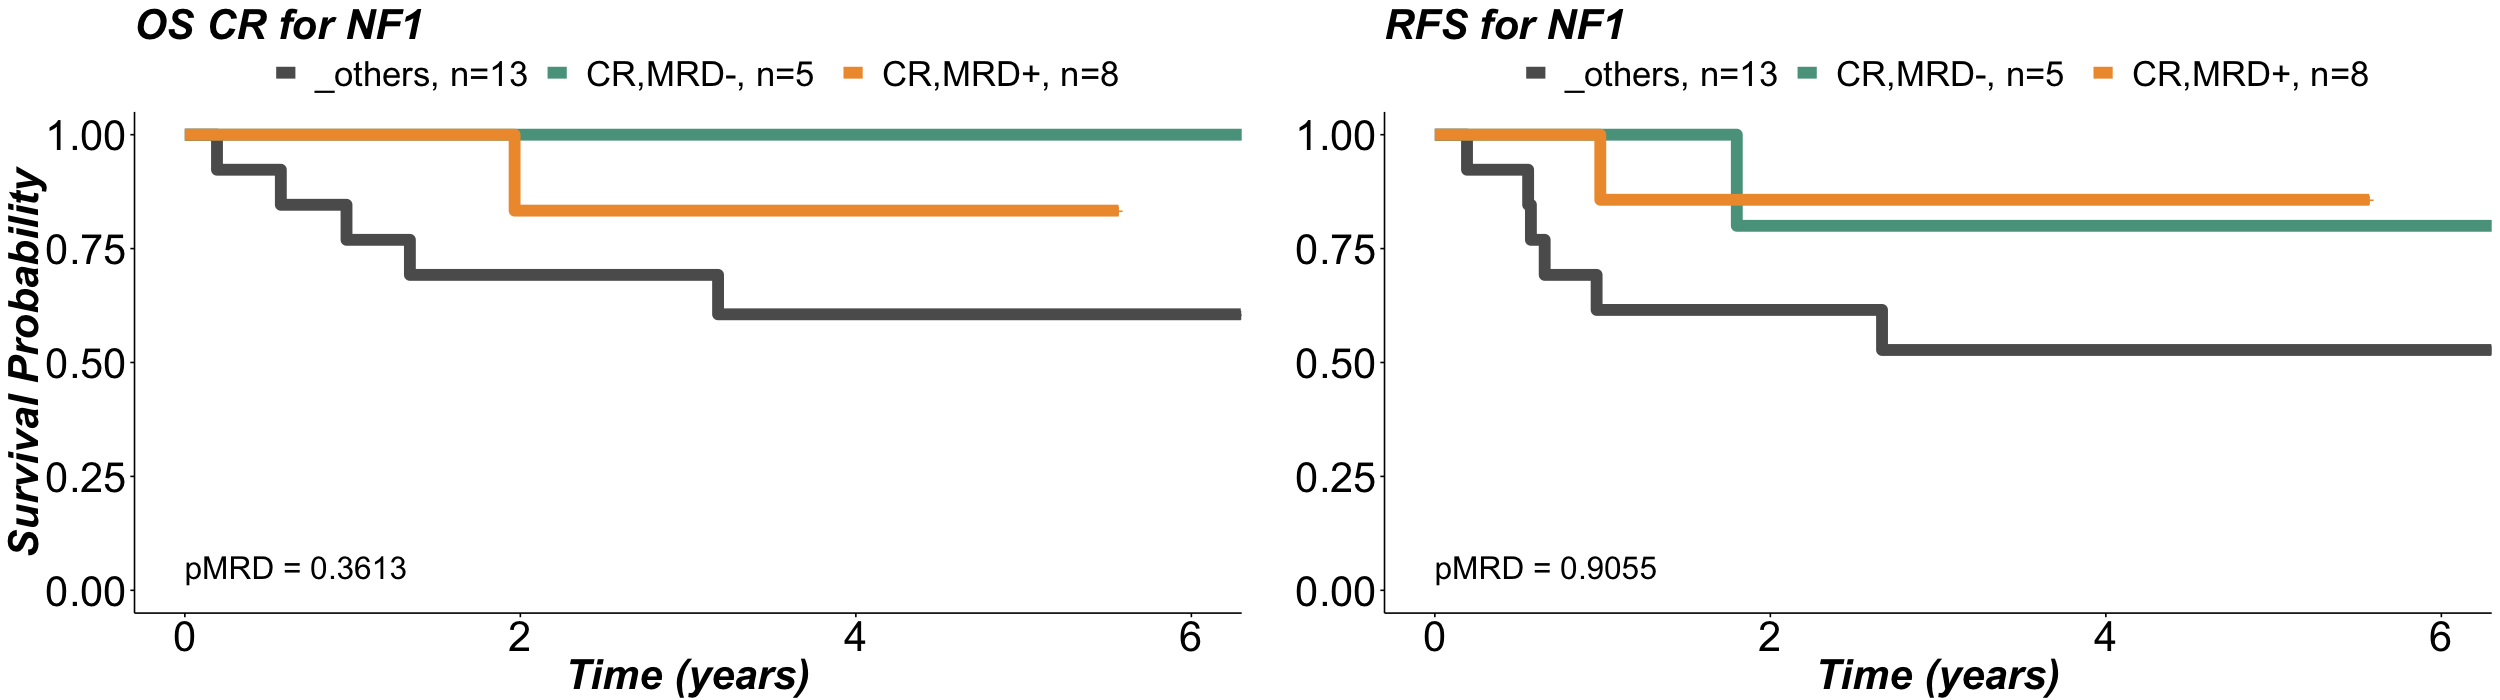

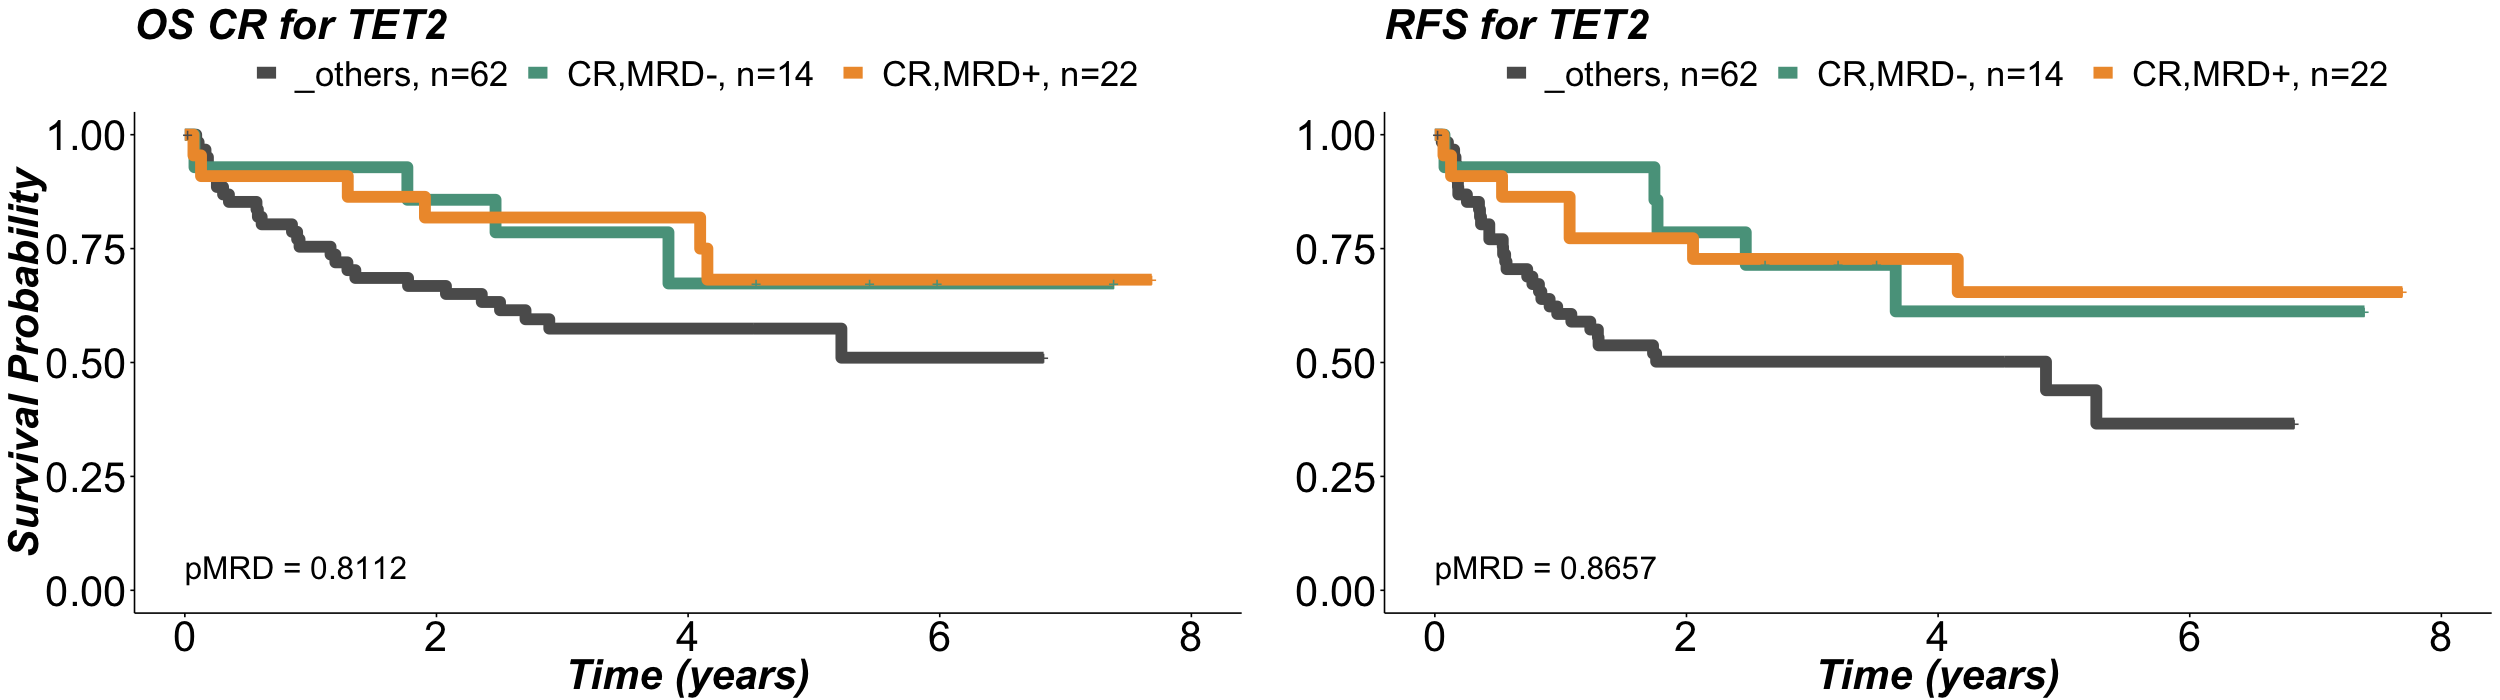

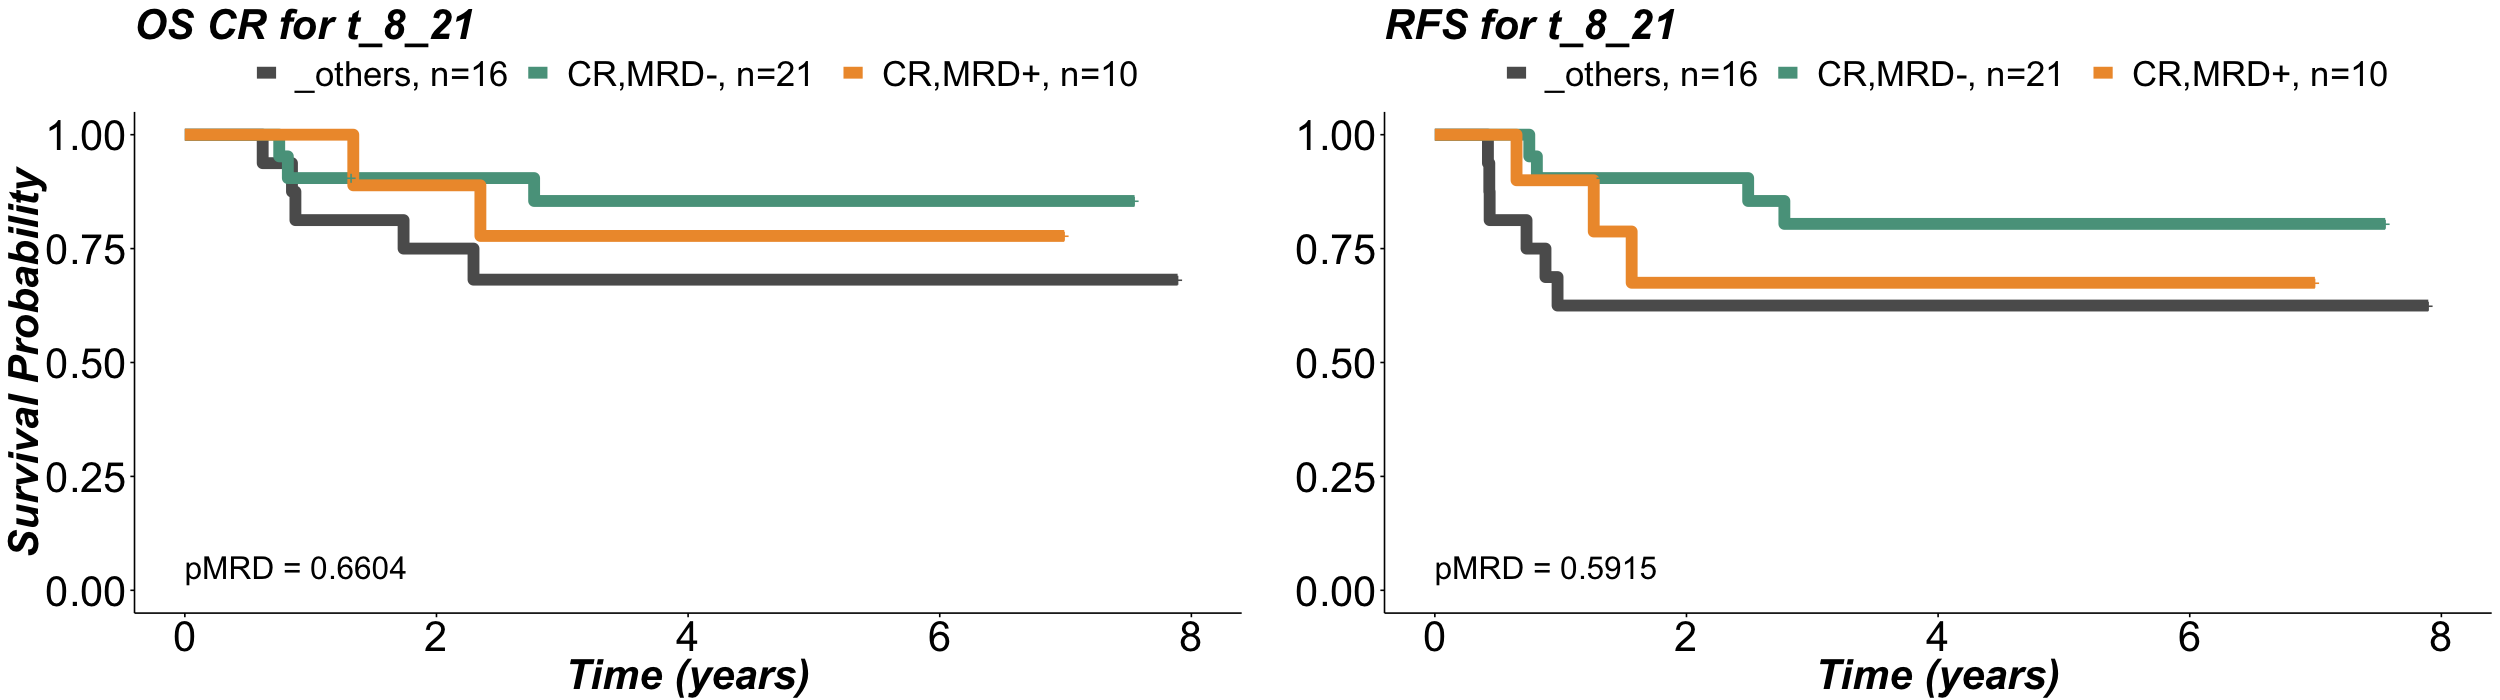

In [227]:
gene_cyto <- colnames(df_merge[,c(5:158)])
gene_cyto <-c("RUNX1","KIT","NF1","TET2","t_8_21")
# pdf("graphs/MRD/gene_cyto_MRD.pdf",22,6)

set_notebook_plot_size(25,7)
for (event in gene_cyto){
    tmp<- df_merge[df_merge[,event]==1,]
    surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
    fit <- survfit(surv_object ~ MRD_status, data = tmp)
    p[[event]] <- try(suppressWarnings(plots_KM_MRD(tmp=tmp,fit=fit,strat=event,leg.labs=c(paste("_others",nrow(tmp[(tmp$MRD_status=="_others") & !is.na(tmp$OS_CR),]),sep=", n="),
                                                     paste("CR,MRD-",nrow(tmp[(tmp$MRD_status=="CR,MRD-") & !is.na(tmp$OS_CR),]),sep=", n="),paste("CR,MRD+",nrow(tmp[(tmp$MRD_status=="CR,MRD+") & !is.na(tmp$OS_CR),]),sep=", n=")))))
    }
# dev.off()

In [244]:
png("MRD_pos.png",width=5000,height=5000,res=200)
grid.arrange(p$RUNX1,p$KIT,p$NF1,p$TET2,p$t_8_21,nrow=5)
dev.off()

pdf 
  2

# END

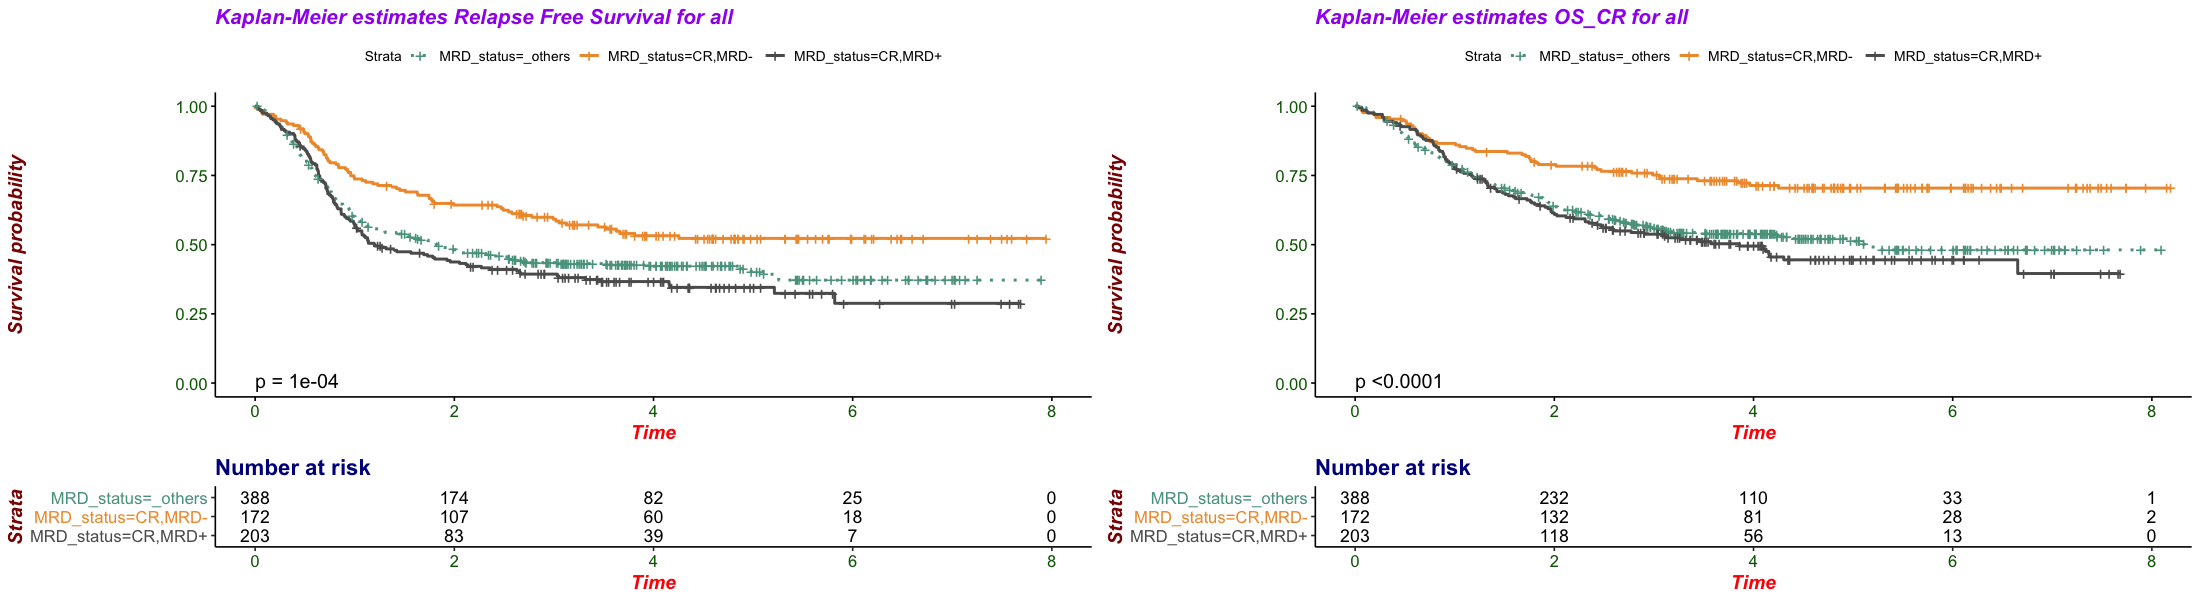

In [122]:
# pdf("graphs/MRD/overall_MRD.pdf",22,6)
tmp<- df_merge
surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
fit <- survfit(surv_object ~ MRD_status, data = tmp)
plots_KM_MRD(tmp,fit)
# dev.off()

# CR MRD Stratification by component

In [ ]:
comp <- colnames(df_merge[,170:192])
# pdf("graphs/MRD/components_MRD.pdf",22,6)
for (ev in comp){
    tmp<- df_merge[df_merge[,ev]==1,]
    surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
    fit <- survfit(surv_object ~ MRD_status, data = tmp)
    plots_KM_MRD(tmp=tmp,fit=fit,strat=ev)
    }
# dev.off()

# CR MRD Special Selection Positive no matter MRD

In [ ]:
set_notebook_plot_size(22,6)
# pdf("graphs/MRD/interesting_good_MRD.pdf",22,6)
gene_cyto_pos <- c("CEBPA_bi","KIT","MYC","NF1","TET2","t_8_21")
for (ev in gene_cyto_pos){
    tmp<- df_merge[df_merge[,ev]==1,]
    surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
    fit <- survfit(surv_object ~ MRD_status, data = tmp)
    plots_KM_MRD(tmp=tmp,fit=fit,strat=ev)
    }
# dev.off()

# CR MRD Special Selection Negative no matter MRD

In [ ]:
set_notebook_plot_size(22,6)
gene_cyto_neg <- c("SRSF2","STAG2","WT1","minusy")
# pdf("graphs/MRD/interesting_poor_MRD.pdf",22,6)
for (ev in gene_cyto_neg){
    tmp<- df_merge[df_merge[,ev]==1,]
    surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
    fit <- survfit(surv_object ~ MRD_status, data = tmp)
    plots_KM_MRD(tmp=tmp,fit=fit,strat=ev)
    }
# dev.off()

# CR MRD Stratification by genes and cyto events

In [108]:
set_notebook_plot_size(22,6)
gene_cyto <- colnames(df_merge[,c(5:158)])
pdf("graphs/MRD/gene_cyto_MRD.pdf",22,6)
for (event in gene_cyto){
    tmp<- df_merge[df_merge[,event]==1,]
    surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
    fit <- survfit(surv_object ~ MRD_status, data = tmp)
    plots_KM_MRD(tmp=tmp,fit=fit,strat=event)
    }
dev.off()

pdf 
  2

# I) INVESTIGATION OF MRD STATUS EFFECT FOR RFS AND OS

In [120]:
library(dummies)
tmp <- df_merge
tmp <-cbind(tmp, dummy(tmp$MRD_status, sep = "_"))
tmp <- tmp %>% rename(CR_MRD_neg = "NA_CR,MRD-", CR_MRD_pos = "NA_CR,MRD+")


In [141]:
## Volcano Plot Univariate
library(ggrepel)  
df <- data.frame(hazard = double(),pvalue = double(),Frequency = double() )
data <- tmp

for (col in c('CR_MRD_neg','CR_MRD_pos',clin,demo)){
    surv_object <- Surv(time = data$os, event = data$os_status)
    fit <- coxph(as.formula(paste("Surv(os, os_status) ~ ",
                       col)), data = data)

    df[col,1:3] <- c(summary(fit)$coef[2],summary(fit)$sctest[["pvalue"]],100*sum(data[,col])/dim(data)[1])                 
     }
df[,"adjusted_pvalue"] <- p.adjust(df$pvalue)
df[,"-log10(adjusted_pvalue)"] <- -log(p.adjust(df$pvalue),10)
df[,"log2(hazard)"] <- log(df$hazard,2)
df["names"] <- rownames(df)
df$Model <- ifelse(df$names %in% genes,"gen",
                  ifelse(df$names %in% cytos,"cyto",
                        ifelse(df$names %in% clin, "clin",
                              ifelse(df$names %in% demo, "demo",
                                    ifelse(df$names %in% eln, "eln","comp")))))
df$Frequency <- ifelse(df$names %in% clin, 5,
                              ifelse(df$names %in% demo, 5, df$Frequency))

colors_analysis <- c(gen="#BFBFBF",cyto="#2b8cbe")
df <- df[order(df$adjusted_pvalue),]
s <- ggplot(df, aes(log2(hazard), -log10(adjusted_pvalue))) + #volcanoplot with log2Foldchange versus pvalue
    geom_point(aes(size=Frequency,col=Model)) + geom_text_repel(data=df[(df["adjusted_pvalue"]<0.1) | (df["log2(hazard)"]< -18),], aes(label=names,fontface=2))+scale_size_continuous(range = c(3,12)) + 
     scale_color_manual(values=colors_analysis,limits=names(colors_analysis))+  ## respect color in feature importance
    theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=12),axis.title=element_text(size=14,face="bold"))  + theme(legend.position="none")


## Multivariate Plot

data <- tmp
df_multi <- NULL
i <- 1
for (i in c(1:100)){
    res1 <- cv.glmnet(data.matrix(data[,c('CR_MRD_neg','CR_MRD_pos',clin,demo)]), Surv(data$os,data$os_status), family="cox",alpha=1,nfolds=10)
    df_multi <- cbind(df_multi,as.matrix(coef(res1,s="lambda.min")))
    i <- i+1
    }

l <- data.frame(coef = rowSums(df_multi)/100)
l$names <- rownames(l)
l$Model <- ifelse(l$names %in% gen,"gen",
              ifelse(l$names %in% cyto,"cyto",
                    ifelse(l$names %in% clin, "clin",
                          ifelse(l$names %in% demo, "demo",
                                ifelse(l$names %in% eln,
                                       "eln","comp")))))
t <- ggplot(l[l$coef!=0,],aes(x=names,y=coef,fill=Model))+geom_bar(stat="identity")+coord_flip()+
theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=12),axis.title=element_text(size=14,face="bold"))#+
# scale_fill_manual(values=colors_analysis,limits=names(colors_analysis))
    


Warning message:
“Removed 11 rows containing missing values (geom_point).”

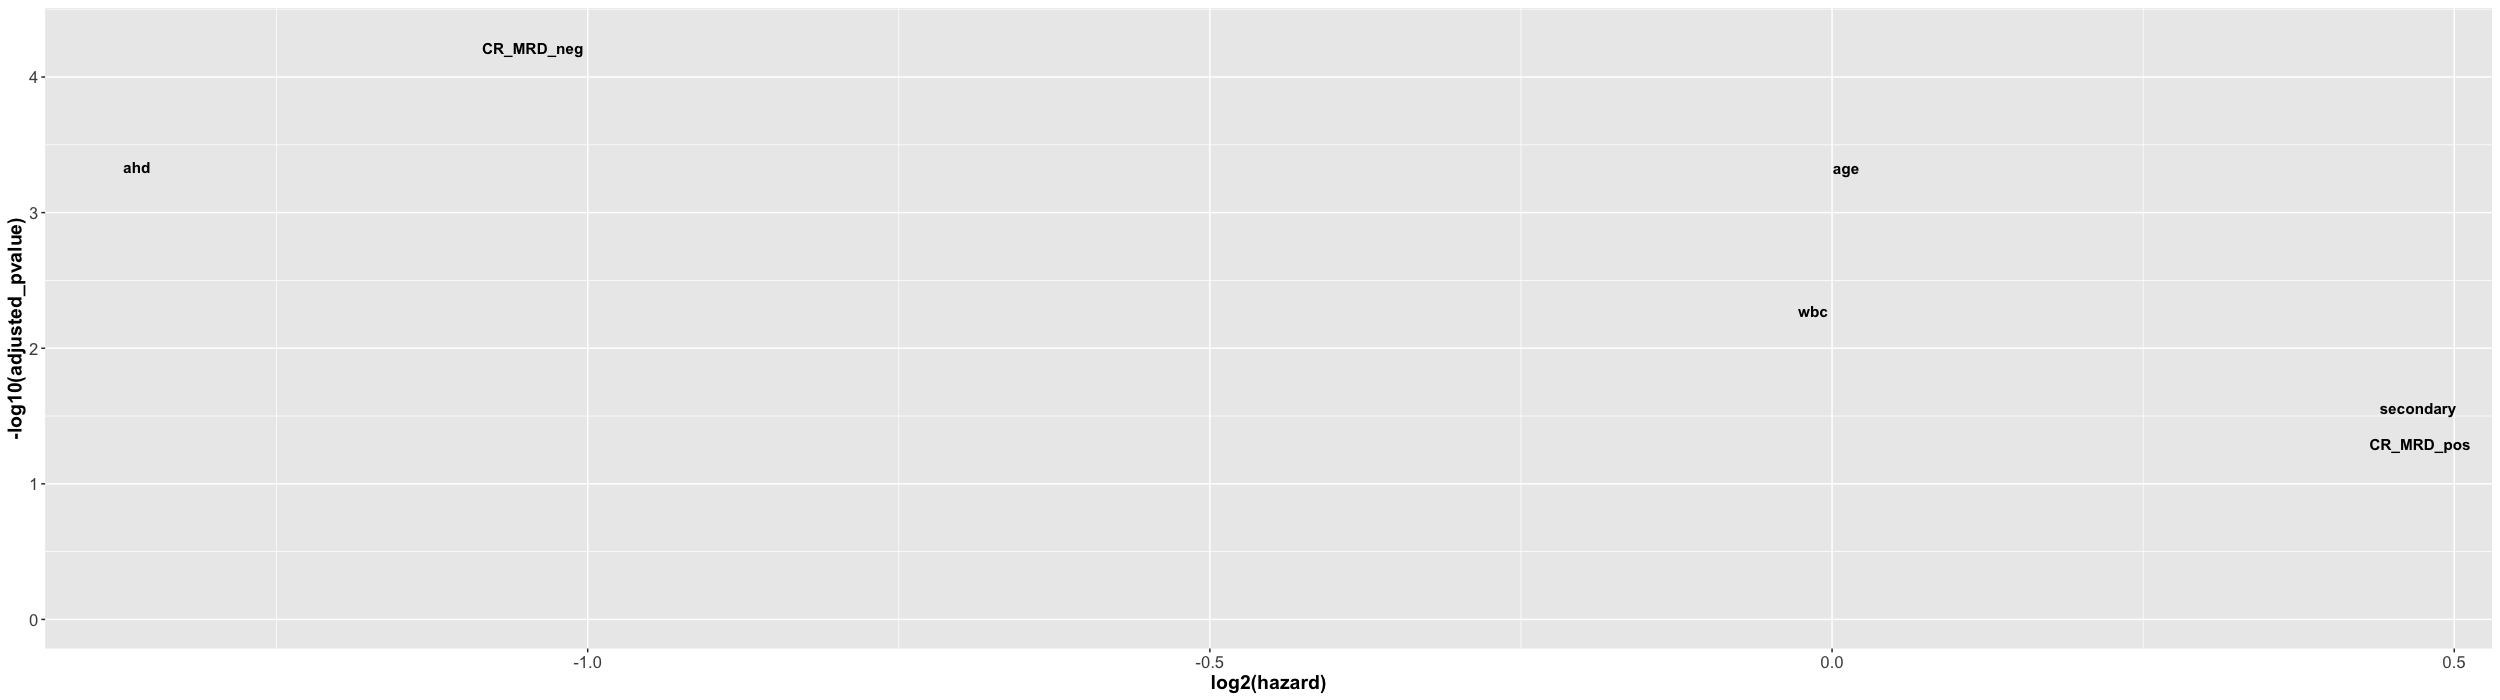

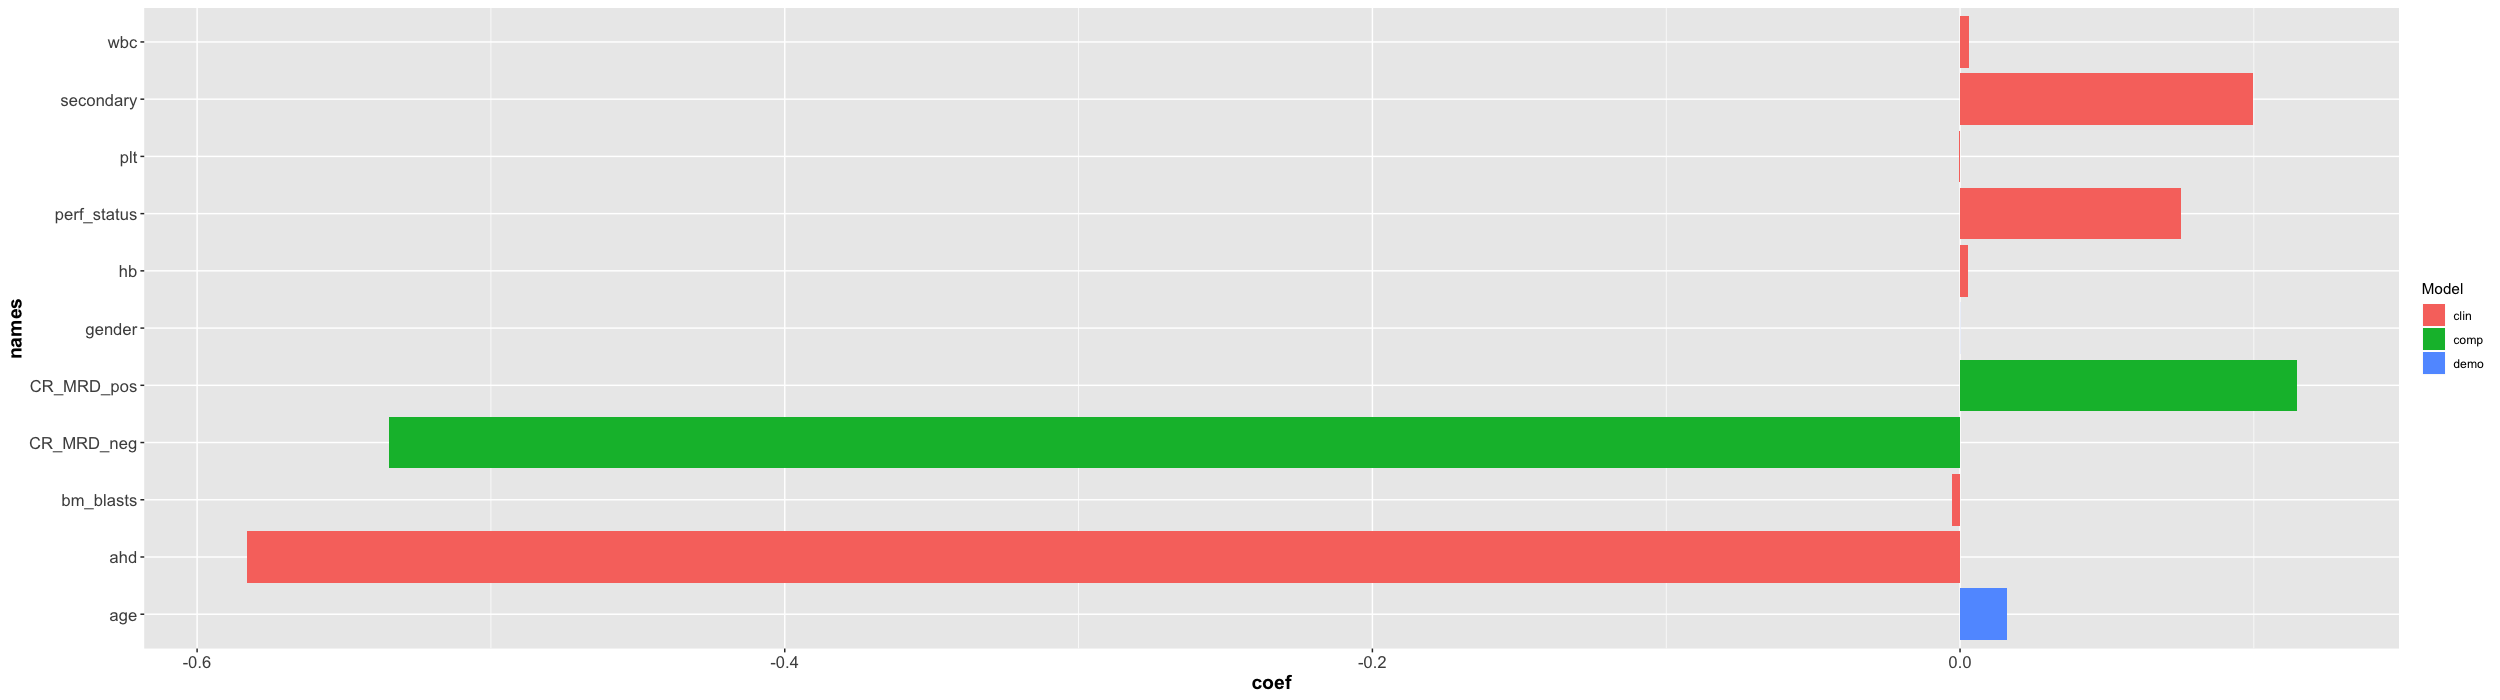

In [142]:
s
t